# What I think needs to be refactored

- Each of the code under the for statements in the DistNodeNoParent can be its own function
  - Logic within each of the if statement could also be refactored into separate functions, for example, the logic for getting the distribution for discrete variables can be in a separate function, same for logic for getting distribution for any continuous variables.
  - The fitting function from fitter should be adjusted to avoid the excessive printing. Any way for using tqdm here?

- The for loop within SimNodeNoParent should be a separate function

- The SimulateAvailability Function should only produce an availability matrix, rather than concatenate it to the existing long format dataframe

- Each of the if statements within FitAlternativeRegression should be it's own separate function for fitting logistic regression vs. linear...

- We should write functions that take in a format of regression and produces the needed data. (for all regression equations)

- The for loop that simulates data N times and estimates any models should be written as a helper function.

- Helper function to plot the distribution of causal effects

- Helper function to recompute the regressions after the perturbations of variables.

- All the conditions are also to be written as separate methods.

- We have plenty of parameters that repeat themselves in multiple methods. I think it would be beneficial to create a parameter object that would store all these parameters and allow us to call methods using only one parameter. This will be helpful (in my opinion) while experimenting with different model specifications for example; We would not have to create numerous variables each time for each of the models. Instead, we will create an object (it should be a class in my opinion) from a collection of parameters, then just insert that class in all of our methods for that specific model. The parameters will be attributes of the class.

In [479]:
%load_ext pycodestyle_magic

In [626]:
%pycodestyle_on

# Importing packages 

In [627]:
import sys
sys.path.append('../../src/')

In [628]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import copy
from scipy import sparse
import scipy.stats
import random
from fitter import Fitter
import attr
from causalgraphicalmodels import CausalGraphicalModel, StructuralCausalModel
from collections import defaultdict, OrderedDict
import pylogit as pl
import viz
from array import array
import json
from scipy.stats import multivariate_normal

# 0. Old Code - To be removed after review

## 0.1. Function Definitions

In [486]:
# def DistNodeNoParent(data_long,
#                      alt_id_col,
#                      obs_id_col,
#                      alt_spec_dic,
#                      alt_name_dic,
#                      ind_spec,
#                      trip_spec,
#                      var_types,
#                      cont_dists=None):
#     """
#     Function to find the distribution of specific variables
#     from a long format dataset.
    
#     Parameters
#     ----------
#     data_long: Pandas DataFrame
#         Dataset in long format from which variable
#         distribution is to be found.
        
#     alt_id_col: string
#         Name of the column with alternative ids.
        
#     obs_id_col: string
#         Name of the column with observation ids.
        
#     alt_spec_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a list of strings representing the name of
#         variables without parents per alternative.
        
#     alt_name_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a string representing the name of the 
#         alternative.
        
#     ind_spec: list
#         List containing strings of the names of 
#         individual specific variables.
        
#     trip_spec: list
#         List containing string of the names of 
#         trip specific variables.
        
#     var_types: dictionary
#         Dictionary with keys as strings of names of variables
#         from long format dataset, and values for each key are
#         the type of variables (e.g.: 'categorical vs. continuous').
        
#     cont_dists: list
#         List of continuous RVs distribution names from scipy.
        
#     Returns
#     -------
#     a nested dictionary with keys as variable names and values
#     as dictionaries containing both the distribution name and
#     its parameters.
#     """
    
#     params_dict = {}

#     # Code for Individual Specific Variables
#     for ind in ind_spec:
#         # generate array of values for individual specific variable
#         ind_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][ind].unique()[0]) for x in data_long[obs_id_col].unique()])  
#         # Get distribution if variable is categorical
#         var_type = var_types[ind]
#         if var_type in ['categorical', 'numerical']:
#             # If only one category
#             if len(ind_var.unique()) == 1:
#                 params_dict.setdefault(ind,{})['distribution'] = 'constant'
#                 params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
#             # If more than one category
#             else:
#                 params_dict.setdefault(ind,{})['distribution'] = 'categorical'
#                 # Count frequency of values and store it as paramater of distribution
#                 np_array_range = np.arange(ind_var.max()+1)
#                 array_bincount = np.bincount(ind_var)
#                 probs = array_bincount / len(ind_var)
#                 params_dict.setdefault(ind,{})['parameters'] = [np_array_range,
#                                                   probs]
#         else:
#             # If not categorical but just one unique value
#             if len(ind_var.unique()) == 1:
#                 params_dict.setdefault(ind,{})['distribution'] = 'constant'
#                 params_dict.setdefault(ind,{})['parameters'] = ind_var.unique()
#             # If not categorical but not one unique value
#             else:
#                 # Use the Fitter library to fit distributions
#                 # to the data
#                 fitter_object = Fitter(data=ind_var,
#                                        distributions=cont_dists,
#                                        timeout=60)
#                 fitter_object.fit()
#                 # Get the best distribution and store in dictionary
#                 BestDict = fitter_object.get_best()
#                 params_dict.setdefault(ind,{})['distribution'] = list(BestDict.items())[0][0]
#                 params_dict.setdefault(ind,{})['parameters'] = list(BestDict.items())[0][1]

#     # Code for Alternative Specific Variables
#     # Loop around the different available alternatives
#     for alt in data_long[alt_id_col].unique():
#         # Store data for specific alternative (mode)
#         mode_data = data_long.loc[data_long[alt_id_col] == alt]
#         # Loop around the alternative specific variables in the input dictionary
#         for var in alt_spec_dic[alt]:
#             # If data is to be taken as empirical values
#             if var_types[var] == 'empirical':
#                 # If only one value
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 else:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'empirical'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = np.array(mode_data[var])
#             # If data is categorical
#             elif var_types[var] == 'categorical':
#                 # If only one category
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 else:
#                     # If more than one category, compute the frequency of values
#                     # and store as parameters
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'categorical'
#                     np_array_range = np.arange(mode_data[var].max()+1)
#                     array_bincount = np.bincount(mode_data[var])
#                     probs = array_bincount / len(mode_data[var])
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = [np_array_range,
#                                                                             probs]
#             else:
#                 # If data is not categorical but has one unique value
#                 if len(mode_data[var].unique()) == 1:
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = 'constant'
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = mode_data[var].unique()
#                 # If data is not categorical but has more than one unique value
#                 else:
#                     # Use the Fitter library to fit distributions
#                     # to the data
#                     fitter_object = Fitter(data=mode_data[var],
#                                            distributions=cont_dists,
#                                            timeout=60)
#                     fitter_object.fit()
#                     # Get the best distribution and store in dictionary
#                     BestDict = fitter_object.get_best()
#                     # Add name of alternative to variable and store distriburion & parameters
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['distribution'] = list(BestDict.items())[0][0]
#                     params_dict.setdefault(var +'_'+ alt_name_dic[alt], {})['parameters'] = list(BestDict.items())[0][1]

#     # Trip Specific Variable (maybe combine with individual specific variables)
#     # Loop around trip (observation) specific variables
#     for var in trip_spec:
#         # generate array of values for trip specific variable
#         trip_var = pd.Series([(data_long.loc[data_long[obs_id_col] == x][var].unique()[0]) for x in data_long[obs_id_col].unique()])
#         # If data is to be taken as empirical values
#         if var_types[var] == 'empirical':
#             # If data has one unique value
#             if trip_var.unique() == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = np.array(trip_var.unique())
#             # If data has more than one unique value
#             else:
#                 params_dict.setdefault(var, {})['distribution'] = 'empirical'
#                 params_dict.setdefault(var, {})['parameters'] = np.array(trip_var)
#         # Get distribution if variable is categorical
#         elif var_types[var] == 'categorical':
#             # If only one category
#             if len(trip_var.unique()) == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
#             # If more than one category
#             else:
#                 params_dict.setdefault(var, {})['distribution'] = 'categorical'
#                 # Count frequency of values and store it as paramater of distribution
#                 np_array_range = np.arange(trip_var.max()+1)
#                 array_bincount = np.bincount(trip_var)
#                 probs = array_bincount / len(trip_var)
#                 params_dict.setdefault(var, {})['parameters'] = [np_array_range,
#                                                   probs]
#         else:
#             # If not categorical but just one unique value
#             if len(trip_var.unique()) == 1:
#                 params_dict.setdefault(var, {})['distribution'] = 'constant'
#                 params_dict.setdefault(var, {})['parameters'] = trip_var.unique()
#             # If not categorical but just one unique value
#             else:
#                 # Use the Fitter library to fit distributions
#                 # to the data
#                 fitter_object = Fitter(data=trip_var,
#                                        distributions=cont_dists,
#                                        timeout=60)
#                 fitter_object.fit()
#                 # Get the best distribution and store in dictionary
#                 BestDict = fitter_object.get_best()
#                 params_dict.setdefault(var, {})['distribution'] = list(BestDict.items())[0][0]
#                 params_dict.setdefault(var, {})['parameters'] = list(BestDict.items())[0][1]

#     return params_dict


# def SimNodeNoParent(params_dict, size=1000):
#     """
#     Funtion to simulate data of size N based on specified
#     distribution/parameters found by the fitter package.
    
#     Paremeters
#     ----------
#     dist_params: dictionary
#         The variable distribution dictionary resulting from
#         `FindLongDataDist`.
        
#     size: int
#         Size of the desired simulated dataset, default value
#         is 1000 observations.
    
#     Returns
#     -------
#     DataFrame object with simulated data based on specified distributions
#     """
#     # Create Empty DataFrame with keys from params_dict
#     Sim_Df = pd.DataFrame(columns=list(params_dict.keys()))
#     Sim_Df = Sim_Df.fillna(0)
    
#     # Loop around each of the variables in params_dict
#     # and simulate data for them
#     for column in list(params_dict.keys()):
#         # Simulate data for categorical variables
#         if params_dict[column]['distribution'] == 'categorical':
#             value = params_dict[column]['parameters'][0]
#             freq = params_dict[column]['parameters'][1]
#             data_sim = np.random.choice(a=value,
#                                         p=freq,
#                                         size=size)
#             Sim_Df[column] = data_sim
        
#         # Simulate variables for data with a single unique value
#         elif params_dict[column]['distribution'] == 'constant':
#             data_sim = params_dict[column]['parameters']
#             Sim_Df[column] = data_sim
        
#         # Simulate data using values from array, sampling
#         # with replacement
#         elif params_dict[column]['distribution'] == 'empirical':
#             data_sim = np.random.choice(params_dict[column]['paramaters'], size=size)
#             Sim_Df[column] = data_sim
        
#         # Simulate data for continuous variables
#         else:
#             # Get scipy distribution from its
#             # name in the params dictionary
#             dist = getattr(scipy.stats,
#                            params_dict[column]['distribution'])
#             data_sim = dist.rvs(*params_dict[column]['parameters'],
#                                 size=size)
#             Sim_Df[column] = data_sim
        
#     return Sim_Df

# def SimulateAvailability(data_long, sim_data, obs_id_col, alt_name_dict):
#     """
#     Function to simulate alternative availability based on a long format
#     dataset and join the availability data to the simulated dataset
#     resulting from SimDf.
    
#     Parameters
#     ----------
#     data_long: Pandas DataFrame
#         Long format dataframe used for simulating
#         alternative availability.
    
#     sim_data: Pandas DataFrame
#         Wide format dataframe resulting from SimDf
    
#     obs_id_col: string
#         Name of the column in data_long with 
#         observation ids.
    
#     alt_name_dic: dictionary
#         Dictionary with keys as the ordered number
#         of alternatives, and the value for each key
#         is a string representing the name of the 
#         alternative.
        
#     Returns
#     -------
#     Wide format Pandas DataFrame with additional availability
#     columns for each of the alternatives.
    
#     """
    
#     # Create empty Series to hold number of available alternatives
#     series = pd.Series([])
    
#     # Loop around each observation to record the
#     # available number of alternatives for each observation
#     for i, obs in zip(np.arange(len(data_long[obs_id_col].unique())), data_long[obs_id_col].unique()):
#         series[i] = data_long[data_long[obs_id_col] == obs].shape[0]

#     # Simulate number of available alternatives for
#     # each observation in sim_data
#     av_size = sim_data.shape[0]
#     alts_sim = np.random.choice(a=np.arange(series.max()+1),
#                                 p=np.bincount(series)/len(series),
#                                 size=av_size)

#     # Simulate the availability matrix based on number 
#     # of available alternatives
#     N = len(alt_name_dict)
#     av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]
    
#     # Shuffle the available alternatives for each observation
#     # because av_sim will always start with 1s
#     for x in av_sim:
#         np.random.shuffle(x)

#     # Shuffle the availability across different observations
#     np.random.shuffle(av_sim)
    
#     # Create columns for the availability matrix
#     AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]
    
#     # Create alternative availability matrix with AV_columns
#     AV_Df = pd.DataFrame(av_sim, columns=AV_columns)
    
#     # Create an random choice column based on available
#     # alternatives for each observation - This column will
#     # be needed when converting to long data
#     fake_choice = [random.choice(np.nonzero(a == 1)[0]) + 1 for a in np.array(AV_Df)]
#     fake_choice_df = pd.DataFrame(fake_choice, columns=['sim_choice'])
    
#     # Concatenate the simulated data with availability data and fake choice data
#     # and return Sim_DF_AV
#     Sim_DF_AV = pd.concat([sim_data, AV_Df, fake_choice_df], axis=1, sort=False)
#     return Sim_DF_AV

# def FitAlternativeRegression(regressions, reg_types, data):
    
#     """
#     Function to store regression models based on causal graph
#     in a dictionary.
    
#     Parameters
#     ----------
#     regressions: dictionary
#         Dictionary with keys as integers representing the
#         order of regressions. Values of the dictionary
#         are tuples/lists with the first item is a string
#         of the name of the independent variable and the
#         second item is a string of the name of the 
#         dependent variable.
    
#     reg_types: dictionary
#         Dictionary with keys as integers representing the
#         order of regressions. Keys should be similar to the
#         keys from the `regressions` dictionary. Values are
#         strings representing the type of regressions to be
#         ran. **TODO: add more regressions**
        
#     Returns
#     -------
#     Dictionary with keys as the regression name and values
#     as regression models stores. Methods from these fitted
#     models can be accessed through the values of the dictionary.
#     """
    
#     # Initiate the regressions results dictionary
#     regression_results = {}
    
#     # Loop around the regressions
#     for reg in regressions.keys():
#         # If linear regression
#         if reg_types[reg] == 'linear':
#             # Prepare data and initialize model
#             data_x = sm.add_constant(data[regressions[reg][0]])
#             data_y = data[regressions[reg][1]]
#             model = sm.OLS(data_y, data_x)

#             # Fit model
#             results = model.fit()
            
#             # Store model
#             regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
        
#         # If logistic regression **TODO: Expand on
#         # logistic regression
#         if reg_types[reg] == 'logistic':
#             # Prepare data and initialize model
#             data_x = sm.add_constant(data[regressions[reg][0]])
#             data_y = data[regressions[reg][1]]
#             model = sm.Logit(data_y, data_x)

#             # Fit model
#             results = model.fit()
            
#             # Store model
#             regression_results[regressions[reg][1]+'_on_'+regressions[reg][0]] = results
    
#     #if plotting:
#     #    fig = plt.figure(figsize=(12,8))
#     #    fig = sm.graphics.plot_regress_exog(results, X[0], fig=fig)
    
#     return regression_results


# bike_data_params = {'household_size': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.        , 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
#           0.12012987, 0.02997003, 0.00949051, 0.01123876)]},
#  'num_kids': {'distribution': 'categorical',
#   'parameters': [(0, 1, 2, 3, 4, 5, 6),
#    (0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
#           0.00699301, 0.0014985)]},
#  'num_cars': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6., 7., 8.),
#    (0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
#           0.00674326, 0.0024975 , 0.000999  , 0.000999  )]},
#  'num_licensed_drivers': {'distribution': 'categorical',
#   'parameters': [(0., 1., 2., 3., 4., 5., 6.),
#    (1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
#           4.47052947e-02, 9.24075924e-03, 4.99500500e-04)]},
#  'total_travel_distance_drive_alone': {'distribution': 'halfcauchy',
#   'parameters': (0.39999999242619755, 7.6204182567397165)},
#  'total_travel_distance_shared_2': {'distribution': 'halfcauchy',
#   'parameters': (0.299999998957803, 7.584262028819065)},
#  'total_travel_distance_shared_3p': {'distribution': 'halfcauchy',
#   'parameters': (0.2999999999587918, 7.590903048398837)},
#  'total_travel_time_wtw': {'distribution': 'exponnorm',
#   'parameters': (4.461798763613399, 42.0335875728394, 14.161218106029043)},
#  'total_travel_time_dtw': {'distribution': 'fatiguelife',
#   'parameters': (0.5059992383788099, -10.97225146372076, 88.46124182265194)},
#  'total_travel_time_wtd': {'distribution': 'exponnorm',
#   'parameters': (3.4963501604509, 35.01068856093334, 14.76505046778292)},
#  'total_travel_distance_walk': {'distribution': 'halfcauchy',
#   'parameters': (0.29999999866469995, 6.616044249480995)},
#  'total_travel_distance_bike': {'distribution': 'halfcauchy',
#   'parameters': (0.3599999792235668, 5.810827941041648)},
#  'cross_bay': {'distribution': 'categorical',
#   'parameters': [np.array([0, 1]), np.array([0.94005994, 0.05994006])]}}

## 0.2. Estimate Causal Effects for one simulation

In [ ]:
## 4.1 Compute Initial Probabilities Using Estimated Model on Simulated Data

In [ ]:
## init_mnl_model_sim_probs = mnl_model_sim.predict(long_sim_data)

In [ ]:
## 4.2. Independently Generated Variables

In [ ]:
### 4.2.1. Disturb X Independently

In [ ]:
# long_sim_data_naive = copy.deepcopy(long_sim_data)
# long_sim_data_naive['total_travel_distance'] = 0.95 * long_sim_data_naive['total_travel_distance']

In [ ]:
### 4.2.2. Compute Naive Probabilities Using Disturbed data and Estimated Model on Simulated Data

In [ ]:
# naive_probabilities = mnl_model_sim.predict(long_sim_data_naive)
# long_sim_data_naive['naive_probabilities'] = naive_probabilities

In [ ]:
## 4.3. Based on Causal Graph and Estimated Model from Simulated

In [ ]:
# long_sim_data_causal = copy.deepcopy(long_sim_data)

In [ ]:
### 4.3.1. Perturb X and children nodes

In [ ]:
# long_sim_data_causal['total_travel_distance'] = 0.95 * long_sim_data['total_travel_distance']

In [ ]:
### Drive Alone

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1,'total_travel_time'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1,'total_travel_distance'],
#                  drive_alone_reg['total_travel_time_on_total_travel_distance'],
#                  long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])

# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1,'total_travel_distance'],
#                  drive_alone_reg['total_travel_cost_on_total_travel_distance'],
#                  long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])
                                                 

In [ ]:
### Shared-2

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2,'total_travel_time'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2,'total_travel_distance'],
#                  shared_2_reg['total_travel_time_on_total_travel_distance'],
#                  long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2,'total_travel_distance'],
#                  shared_2_reg['total_travel_cost_on_total_travel_distance'],
#                  long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

In [ ]:
### Shared-3+

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3,'total_travel_time'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3,'total_travel_distance'],
#                  shared_3p_reg['total_travel_time_on_total_travel_distance'],
#                  sim_size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3,'total_travel_distance'],
#                  shared_3p_reg['total_travel_cost_on_total_travel_distance'],
#                  sim_size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

In [ ]:
### Walk-Transit-Walk

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4,'total_travel_time'],
#                  wtw_reg['total_travel_cost_on_total_travel_time'],
#                  sim_size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4].shape[0])

In [ ]:
### Drive-Transit-Walk

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5,'total_travel_time'],
#                  dtw_reg['total_travel_cost_on_total_travel_time'],
#                  sim_size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5].shape[0])

In [ ]:
### Walk-Transit-Drive

In [ ]:
# long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6,'total_travel_cost'] =\
#     lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6,'total_travel_time'],
#                  wtd_reg['total_travel_cost_on_total_travel_time'],
#                  sim_size=long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6].shape[0])

In [ ]:
### Walk 

In [ ]:
# No further change of variables since travel distance directly affects the utility.

In [ ]:
### Bike 

In [ ]:
# No further change of variables since travel distance directly affects the utility.

In [ ]:
### 4.3.2. Compute Estimated Probabilities

In [ ]:
# estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal)
# long_sim_data_causal['estimated_probabilities'] = estimated_probabilities

In [ ]:
## 4.4. Based on True Causal Graph and Original Estimated Model

In [ ]:
# true_probabilities = mnl_model.predict(long_sim_data_causal)
# long_sim_data_causal['true_probabilities'] = true_probabilities

In [ ]:
# long_sim_data['init_mnl_model_sim_prob'] = init_mnl_model_sim_prob

In [ ]:
## 4.5. Calculate Causal Effects

In [ ]:
# naive_effect = long_sim_data_naive.loc[long_sim_data_naive['mode_id'].isin([1, 2, 3]),'naive_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
# estimated_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'estimated_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']
# true_effect = long_sim_data_causal.loc[long_sim_data_causal['mode_id'].isin([1, 2, 3]),'true_probabilities'] - long_sim_data.loc[long_sim_data['mode_id'].isin([1, 2, 3]),'initial_probabilities']

In [ ]:
## 4.6. Distribution of Causal Effect by observation

In [ ]:
# plt.figure(figsize=(15,10))
# sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
# sns.distplot(naive_effect, kde=False, label ='Naive Effect', color='goldenrod')
# plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
# plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
# plt.legend(prop={'size': 14})
# plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

# plt.figure(figsize=(15,10))
# sns.distplot(true_effect, kde=False, label ='True Effect', color='dodgerblue')
# sns.distplot(estimated_effect, kde=False, label ='Estimated effect', color='lightcoral')
# plt.xlabel('Causal Effect', fontdict={'fontsize': 12, 'fontweight':'bold'})
# plt.ylabel('Frequency', fontdict={'fontsize': 12, 'fontweight':'bold'})
# plt.legend(prop={'size': 14})
# plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight':'bold'})

# 1. Define functions to be used in notebook

In [630]:
# Functions to replace code within
# DistNodeNoParent
# Function for checking length


def is_unique(var_values):
    """
    Checks whether a variable has one unique value.
    """
    return len(var_values.unique()) == 1


# def is_empirical(var_type):
#     """
#     Checks whether the variable type for the
#     variable of interest is to be taken
#     as a constant value or as numerical values.
#     """
#     return var_type in ['constant', 'numerical']


def is_constant(var_type):  # to be rethought
    """
    Checks whether a variable has a constant
    value.
    """
    return var_type == 'constant'


def is_empirical(var_type):
    """
    Checks whether the variable type for the
    variable of interest is to be taken
    as a constant value or as numerical values.
    """
    return var_type == 'empirical'


def is_categorical(var_type):
    """
    Checks whether the variable type for the
    variable of interest is categorical.
    """
    return var_type == 'categorical'


def get_alt_specific_variable_name(var_name, alt_name):
    """
    Gets the alternative specific variable,
    returns a string starting with variable name and
    ending with alternative name.
    """
    return var_name + '_' + alt_name


def get_constant_dist(var, var_val, alt_name=None):
    """
    Retrives the constant 'distribution' of a
    constant variable.
    """
    constant_dict = defaultdict(dict)
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None \
        else get_alt_specific_variable_name(var, alt_name)
    constant_dict[var_name]['distribution'] = 'constant'
    constant_dict[var_name]['parameters'] = var_val.unique()
    return constant_dict


def get_empirical_dist(var, var_val, alt_name=None):
    """
    Retrives the empirical values of the alternative
    specific variable of interest as its distribution.
    """
    empir_dict = defaultdict(dict)
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None \
        else get_alt_specific_variable_name(var, alt_name)
    empir_dict[var_name]['distribution'] = 'empirical'
    empir_dict[var_name]['parameters'] = np.array(var_val)
    return empir_dict


def get_categorical_dist(var, var_val, alt_name=None):
    """
    Retrives the unique values and the proportions
    of observed values for a categorical alternative
    specific variables.
    """
    categ_dict = defaultdict(dict)
    # If more than one category, compute the frequency of values
    # and store as parameters
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None \
        else get_alt_specific_variable_name(var, alt_name)
    categ_dict[var_name]['distribution'] = 'categorical'
    np_array_range = np.arange(var_val.max() + 1)
    array_bincount = np.bincount(var_val)
    probs = array_bincount / len(var_val)
    categ_dict[var_name]['parameters'] = [np_array_range,
                                          probs]
    return categ_dict


def get_continuous_dist(var, var_val, cont_dists, alt_name=None):
    """
    Retrives the distribution of continuous alternative
    specific variables using the Fitter package.
    """
    cont_dict = defaultdict(dict)
    # Use the Fitter library to fit distributions
    # to the data
    fitter_object = Fitter(data=var_val,
                           distributions=cont_dists,
                           timeout=60,
                           verbose=True)
    fitter_object.fit()
    # Get the best distribution and store in dictionary
    BestDict = fitter_object.get_best()
    # Add name of alternative to variable and store distriburion & parameters
    var_name =\
        var if alt_name is None \
        else get_alt_specific_variable_name(var, alt_name)
    cont_dict[var_name]['distribution'] =\
        list(BestDict.items())[0][0]
    cont_dict[var_name]['parameters'] =\
        list(BestDict.items())[0][1]
    return cont_dict


def get_distribution_dicts(var, var_type, var_val, cont_dists, alt_name=None):
    """
    Helper function to generate a distribution dictionary
    for the variable specified.
    """
    # If data is categorical
    if is_empirical(var_type):
        # If only one category
        if is_unique(var_val):
            # Add name of alternative to variable
            # and store distriburion & parameters
            dist_dic = get_constant_dist(var, var_val, alt_name)
        else:
            dist_dic = get_empirical_dist(var, var_val, alt_name)
    elif is_categorical(var_type):
        if is_unique(var_val):
            dist_dic = get_constant_dist(var, var_val, alt_name)
        else:
            dist_dic = get_categorical_dist(var, var_val, alt_name)
    else:
        # If data is not categorical but has one unique value
        if is_unique(var_val):
            dist_dic = get_constant_dist(var, var_val, alt_name)
        # If data is not categorical but has more than one unique value
        else:
            dist_dic = get_continuous_dist(var, var_val, alt_name, cont_dists)
    return dist_dic


############################################
# Functions to replace functionality for
# fitting distributions for variables
# specific variables that have no parents
# in the causal graph.
############################################


def ind_spec_dist(data_long, obs_id_col, ind_spec, var_types, cont_dists):
    """
    Function that retrieves distributions for all individual
    specific variables.
    """
    ind_spec_dict = defaultdict(dict)
    for ind_var in ind_spec:
        # generate array of values for individual specific variable
        var_val =\
            (data_long[[obs_id_col, ind_var]]
                .drop_duplicates(obs_id_col, inplace=False)
                .loc[:, ind_var]
                .reset_index(drop=True))
        # Get distribution of variable
        var_type = var_types[ind_var]
        ind_var_dic =\
            get_distribution_dicts(ind_var,
                                   var_type,
                                   var_val,
                                   cont_dists)
        ind_spec_dict.update(ind_var_dic)
    return ind_spec_dict


def alt_spec_dist(data_long,
                  alt_id_col,
                  alt_spec_dic,
                  var_types,
                  alt_name_dic,
                  cont_dists):
    """
    Function that retrieves distributions for all alternative
    specific variables.
    """
    all_alt_spec_var_dic = defaultdict(dict)
    for alt_id in data_long[alt_id_col].unique():
        # Store data for specific alternative (mode)
        alt_data = data_long.loc[data_long[alt_id_col] == alt_id]
        alt_spec_var_dic = defaultdict(dict)
        # Loop around the alternative specific
        # variables in the input dictionary
        alt_name = alt_name_dic[alt_id]
        for alt_var in alt_spec_dic[alt_id]:
            var_val = alt_data[alt_var]
            var_type = var_types[alt_var]
            alt_spec_var_dist =\
                get_distribution_dicts(alt_var,
                                       var_type,
                                       var_val,
                                       alt_name,
                                       cont_dists)
            alt_spec_var_dic.update(alt_spec_var_dist)
        all_alt_spec_var_dic.update(alt_spec_var_dic)
    return all_alt_spec_var_dic


def trip_spec_dist(data_long, obs_id_col, trip_spec, var_types, cont_dists):
    """
    Function that retrieves distributions for all trip
    specific variables.
    """
    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    trip_spec_dict = defaultdict(dict)
    for trip_var in trip_spec:
        # generate array of values for trip specific variable
        var_val =\
            (data_long[[obs_id_col, trip_var]]
                .drop_duplicates(obs_id_col, inplace=False)
                .loc[:, trip_var]
                .reset_index(drop=True))
        var_type = var_types[trip_var]
        # If data is to be taken as empirical values
        trip_spec_var_dist =\
            get_distribution_dicts(trip_var,
                                   var_type,
                                   var_val,
                                   cont_dists)
        trip_spec_dict.update(trip_spec_var_dist)
    return trip_spec_dict


# Define the main function
def get_dist_node_no_parent(data_long,
                            alt_id_col,
                            obs_id_col,
                            alt_spec_dic,
                            alt_name_dic,
                            ind_spec,
                            trip_spec,
                            var_types,
                            cont_dists=None):
    """
    Function to find the distribution of specific variables
    from a long format dataset.

    Parameters
    ----------
    data_long: Pandas DataFrame
        Dataset in long format from which variable
        distribution is to be found.

    alt_id_col: string
        Name of the column with alternative ids.

    obs_id_col: string
        Name of the column with observation ids.

    alt_spec_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a list of strings representing the name of
        variables without parents per alternative.

    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the
        alternative.

    ind_spec: list
        List containing strings of the names of
        individual specific variables.

    trip_spec: list
        List containing string of the names of
        trip specific variables.

    var_types: dictionary
        Dictionary with keys as strings of names of variables
        from long format dataset, and values for each key are
        the type of variables (e.g.: 'categorical vs. continuous').

    cont_dists: list
        List of continuous RVs distribution names from scipy.

    Returns
    -------
    a nested dictionary with keys as variable names and values
    as dictionaries containing both the distribution name and
    its parameters.
    """
    params_dict = defaultdict(dict)

    # Code for Individual Specific Variables
    print("Getting Distributions of Individual Specific Variables...")
    print("---------------------------------------------------------")
    ind_spec_dic_params = ind_spec_dist(data_long,
                                        obs_id_col,
                                        ind_spec,
                                        var_types,
                                        cont_dists)
    params_dict.update(ind_spec_dic_params)
    print("Done...")

    # Code for Alternative Specific Variables
    # Loop around the different available alternatives
    print("Getting Distributions of Alternative Specific Variables...")
    print("----------------------------------------------------------")
    alt_spec_dic_params = alt_spec_dist(data_long,
                                        alt_id_col,
                                        alt_spec_dic,
                                        var_types,
                                        alt_name_dic,
                                        cont_dists)
    params_dict.update(alt_spec_dic_params)
    print("Done...")

    # Trip Specific Variable (maybe combine with individual specific variables)
    # Loop around trip (observation) specific variables
    print("Getting Distributions of Trip Specific Variables...")
    print("---------------------------------------------------------")
    trip_spec_dic_params = trip_spec_dist(data_long,
                                          obs_id_col,
                                          trip_spec,
                                          var_types,
                                          cont_dists)
    params_dict.update(trip_spec_dic_params)
    print("Done...")

    return params_dict

In [631]:
# Write functions to replace functionality
# in SimNodeNoParent


def sim_categorical(var_dist_params, size):
    """
    Function to simulate data for
    a categorical/Discrete variable.
    """
    values = var_dist_params[0]
    freq = var_dist_params[1]
    data_sim = np.random.choice(a=values,
                                p=freq,
                                size=size)
    return data_sim


def sim_constant(var_dist_params):
    """
    Function to simulate data for a
    'constant' variable, in other words,
    a variable that has one empirical value.
    """
    data_sim = var_dist_params
    return data_sim


def sim_empirical(var_dist_params, size):
    """
    Function to sample with replacement
    for a variable.
    """
    data_sim = np.random.choice(var_dist_params, size=size)
    return data_sim


def sim_continuous(var_dist, var_dist_params, size):
    """
    Function to simulate data from a continuous
    distribution.
    """
    # Get scipy distribution from its
    # name in the params dictionary
    dist = getattr(scipy.stats,
                   var_dist)

    data_sim = dist.rvs(*var_dist_params,
                        size=size)
    return data_sim


def sim_from_distribution(var_dist, var_dist_params, size):
    """
    Funtion to simulate data of size N based type of dist
    and the distribution parameters.
    """
    if is_categorical(var_dist):
        sim_array = sim_categorical(var_dist_params, size)
        # Simulate variables for data with a single unique value
    elif is_constant(var_dist):
        sim_array = sim_constant(var_dist_params)
        # Simulate data using values from array, sampling
        # with replacement
    elif is_empirical(var_dist):
        sim_array = sim_empirical(var_dist_params, size)
        # Simulate data for continuous variables
    else:
        sim_array = sim_continuous(var_dist, var_dist_params, size)
    return sim_array


def sim_node_no_parent(params_dict, size=1000):
    """
    Funtion to simulate data of size N based on specified
    distribution/parameters found by the fitter package.

    Paremeters
    ----------
    dist_params: dictionary
        The variable distribution dictionary resulting from
        `FindLongDataDist`.

    size: int
        Size of the desired simulated dataset, default value
        is 1000 observations.

    Returns
    -------
    DataFrame object with simulated data based on specified distributions
    """
    # Create Empty DataFrame with keys from params_dict
    sim_df = pd.DataFrame(columns=list(params_dict.keys()))
    sim_df = sim_df.fillna(0)

    for column in list(params_dict.keys()):
        variable = params_dict[column]
        var_dist = variable['distribution']
        var_dist_params = variable['parameters']
        sim_df[column] = sim_from_distribution(var_dist,
                                               var_dist_params,
                                               size)

    return sim_df

In [632]:
# Functions to replace within SimulateAvailability

# Function to record number of available alternatives
# in each observation


def get_num_of_av_alts(data_long, obs_id_col):
    """
    Get the number of available alternatives
    from a long format dataset.
    """
    # Create Empty Series to store num of
    # available alternatives
    series = pd.Series([])
    # Get the unique observations
    observations = data_long[obs_id_col]
    unique_observations = observations.unique()
    index_observations = np.arange(len(unique_observations))
    # loop around unique observations and populate
    # the empty series
    for i, obs in zip(index_observations, unique_observations):
        series[i] = data_long[observations == obs].shape[0]
    return series


# Function to simulate availability matrix
def sim_availability_matrix(num_alts, sim_size, alt_name_dict):
    """
    Get the availability matrix based on the number of
    available alternatives, the simulation size,
    and the alternative name dictionary
    """
    # Simulate number of available alternatives for
    # each observation in sim_data
    av_size = sim_size
    alts_sim = np.random.choice(a=np.arange(num_alts.max()+1),
                                p=np.bincount(num_alts)/len(num_alts),
                                size=av_size)

    # simulate the availability matrix based on number
    # of available alternatives
    N = len(alt_name_dict)
    av_sim = [np.array([1] * K + [0]*(N-K)) for K in alts_sim]

    # Shuffle the available alternatives for each observation
    # because av_sim will always start with 1s
    for x in av_sim:
        np.random.shuffle(x)

    # Shuffle the availability across different observations
    np.random.shuffle(av_sim)

    # Create columns for the availability matrix
    AV_columns = [alt_name_dict[i]+'_AV' for i in alt_name_dict.keys()]

    # Create alternative availability matrix with AV_columns
    AV_Df = pd.DataFrame(data=av_sim, columns=AV_columns)
    return AV_Df


def simulate_availability(data_long, obs_id_col, alt_name_dict, sim_size=1000):
    """
    Function to simulate alternative availability based on a long format
    dataset and join the availability data to the simulated dataset
    resulting from SimDf.

    Parameters
    ----------
    data_long: Pandas DataFrame
        Long format dataframe used for simulating
        alternative availability.

    sim_size: int
        Size of the simulated dataset

    obs_id_col: string
        Name of the column in data_long with
        observation ids.

    alt_name_dic: dictionary
        Dictionary with keys as the ordered number
        of alternatives, and the value for each key
        is a string representing the name of the
        alternative.

    Returns
    -------
    Wide format Pandas DataFrame with additional availability
    columns for each of the alternatives.

    """
    # Get an array of the number of available alternatives
    num_alts = get_num_of_av_alts(data_long,
                                  obs_id_col)

    # Create an availability dataframe
    AV_Df = sim_availability_matrix(num_alts,
                                    sim_size,
                                    alt_name_dict)

    return AV_Df

# Function to generate fake choice column
# this functionality will be relocated to
# a different function, most likely a function
# that merges availability matrix and simulated
# data or a function that converts to long_data


def sim_fake_choice_col(AV_matrix):
    """
    Simulates fake choice column
    needed in the simulated wide format
    dataset.
    """
    # Create an random choice column based on available
    # alternatives for each observation - This column will
    # be needed when converting to long data -- this will
    # be moved to a different column
    available_alt_indices = lambda av_row: np.nonzero(av_row == 1)[0]
    fake_choice = [random.choice(available_alt_indices(a)) + 1
                   for a in np.array(AV_matrix)]
    return fake_choice

120:5: E731 do not assign a lambda expression, use a def


In [636]:
def is_linear(reg_type):
    """
    Checks whether a regression type is linear.
    """
    return reg_type == 'linear'


def is_bin_log(reg_type):
    """
    Checks whether a regression type is binomial.
    """
    return reg_type == 'binomial'


def fit_linear_reg(X, Y):
    """
    Fits OLS linear regression to input data.
    """
    # Prepare data and initialize model
    X = sm.add_constant(X)
    lin_reg = sm.OLS(Y, X)
    # Fit model
    model = lin_reg.fit()
    return model


def fit_binomial_reg(X, Y):
    """
    Fits binomial regression to input data.
    """
    # Prepare data and initialize model
    X = sm.add_constant(X)
    bin_reg = sm.Logit(Y, X)
    # Fit model
    model = bin_reg.fit()
    return model


def fit_multinomial_reg(X, Y):
    """
    Fits multinomial regression to input data.
    """
    # Prepare data and initialize model
    # regressions[reg][0] COULD be a list
    # Check the length, and reshape if
    # array is 1d.
    if len(X.shape) == 1:
        X = X.values.reshape((-1, 1))

    multinomial_reg = LogisticRegression(multi_class='multinomial',
                                         solver='newton-cg')
    # Fit model
    model = multinomial_reg.fit(X, Y)
    return model


def get_regression_name(x_var, y_var):
    """
    Gets regression name based on the name of
    input variables.
    """
# TODO: Generalize if you have more than one exp variable
#     if len(y_var) == 1:
#         reg_name = y_var + '_on_' + x_var
#     else: ## need to compe up with a better way to dump dep variable
#         reg_name = json.dumps(y_var) + '_on_' + x_var
    return y_var + '_on_' + x_var


def fit_regression(regression, reg_type, data):
    """
    Fits regression and stores model output based
    on the regression type and the data.

    Parameters
    ----------

    regression: tuple
        regression to be fit

    reg_type: str
        regression type to be used. Currently, this
        parameter can take either 'linear', 'binomial', or 'multinomial'.

    data: DataFrame
        The dataframe including all the necessary data.

    Returns
    -------
    Dictionary with the key as the name of the regression
    and its value as the stored model.
    """
    reg_result = defaultdict(dict)
    x_var = regression[0]
    y_var = regression[1]
    x_data = data[x_var]
    y_data = data[y_var]
    # If linear regression
    if is_linear(reg_type):
        model = fit_linear_reg(x_data, y_data)
        regression_name = get_regression_name(x_var, y_var)
        # Store model results
        reg_result[regression_name] = model

    # If logistic regression **TODO: Expand on
    # logistic regression
    elif is_bin_log(reg_type):
        model = fit_binomial_reg(x_data, y_data)
        regression_name = get_regression_name(x_var, y_var)
        # Store model results
        reg_result[regression_name] = model
    else:
        # Store model - TODO: come up with a better representation
        # of the regression name in the dictionary.
        model = fit_multinomial_reg(x_data, y_data)
        regression_name = get_regression_name(x_var, y_var)
        # Store model results
        reg_result[regression_name] = model
    return reg_result


def fit_alternative_regression(regressions, reg_types, data):
    # Loop around the regressions
    """
    Function to store regression models based on causal graph
    in a dictionary.

    Parameters
    ----------
    regressions: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Values of the dictionary
        are tuples/lists with the first item is a string
        of the name of the independent variable and the
        second item is a string of the name of the
        dependent variable.

    reg_types: dictionary
        Dictionary with keys as integers representing the
        order of regressions. Keys should be similar to the
        keys from the `regressions` dictionary. Values are
        strings representing the type of regressions to be
        ran.

    Returns
    -------
    Dictionary with keys as the regression name and values
    as regression models stores. Methods from these fitted
    models can be accessed through the values of the dictionary.
    """

    reg_results = defaultdict(dict)
    for reg_id in regressions.keys():
        regression = regressions[reg_id]
        reg_type = reg_types[reg_id]
        # If linear regression
        reg_result = fit_regression(regression,
                                    reg_type,
                                    data)
        reg_results.update(reg_result)

    return reg_results

In [635]:
def lin_reg_pred(X, fitted_reg, size, causal_scale=None):
    """
    Uses the fitted regression to produce predictions.
    Currently does not support any transformation
    of predictors.

    Parameters
    ----------
    X: array-like
        predictor array

    fitted_reg: Statsmodels regression model
        Currently only supports statsmodels
        regression models.

    size: int
        Size of dataset

    scale: int or list
        int or list to scale the fitted coefficients
        for each of the estimated parameters.

    Returns
    -------
    Array of predictions based on the fitted regression
    model.
    """
    # Setup the predictor variables
    predictor = sm.add_constant(X)

    # Get the estimate parameters
    fitted_reg_params = fitted_reg.params.values

    # get covariance matrix
    fitted_reg_cov = fitted_reg.cov_params().values

    # Adjust the coefficients accouting for variabce
    coefs = multivariate_normal.rvs(mean=fitted_reg_params,
                                    cov=fitted_reg_cov,
                                    size=size)

    # scale some parameters if desired causal effect is bigger
    if causal_scale is not None:
        scale_array = np.array(causal_scale)
        coefs[:, 1:] = coefs[:, 1:] * scale_array

    # Generate noise
    noise = np.random.normal(loc=0,
                             scale=fitted_reg.resid.std(),
                             size=size)
    # Compute predictions
    dot_prod = np.einsum('ij, ij->i', coefs, predictor)
    prediction = dot_prod + noise

    return prediction

In [637]:
def plot_params(sim_par, model, fig_size):
    """
    Function to plot parameters from simulated data.

    Parameters
    ----------
    sim_par: Pandas Series or Pandas Column
        Pandas Series or column from DataFrame containing
        coefficients from the estimated models based on
        simulated data.

    model: Pylogit model.
        Estimated data generating model to compare
        estimated parameters based on simulated data
        to.

    size: tuple
        Figure size

    Returns
    -------
    Seaborn figure of the distribution of estimated parameters
    based on simulated data.
    """
    # Create bins for the histogram
    bins = np.linspace(sim_par.min(), sim_par.max(), 10)

    # Initialize the figure size
    plt.figure(figsize=fig_size)

    # Plot the distribution
    sns.distplot(sim_par, kde=False, bins=bins, label='Simulated Parameters')

    # Add vertical line for the data generating parameter
    plt.axvline(model.coefs[sim_par.name],
                color='black',
                ls='--',
                label='Data Generating Parameter')

    # Add a title for the figure
    plt.title(label='Histogram of ' + '"' + sim_par.name + '"',
              fontdict={'fontsize': 16})

    # Add a y-label
    plt.ylabel('Frequency', rotation=0, labelpad=50)

    # Add a legend
    plt.legend()


def find_outliers(data, threshold=3.5):
    """
    Function to remove outlier data, based on
    the median absolute deviation from the median.
    Note that the function supports asymmetric
    distributions and is based on code from the
    included reference

    Parameters
    ----------
    data: Pandas Series-line
        Series-like containing the simulated
        data in wide format.

    threshold: float
        Threshold of the Median Absolute Deviation
        above which data should be removed

    Returns
    -------
    Array with True values representing index
    of non-outliers

    References
    ----------
    https://eurekastatistics.com/using-the-median-
    absolute-deviation-to-find-outliers/

    TODO:
    -----
    We need to discuss whether this approach is
    appropriate for dropping outlier observations
    """

    m = np.median(data)
    abs_dev = np.abs(data - m)
    left_mad = np.median(abs_dev[data <= m])
    right_mad = np.median(abs_dev[data >= m])
    data_mad = left_mad * np.ones(len(data))
    data_mad[data > m] = right_mad
    z_score = abs_dev / data_mad
    z_score[data == m] = 0
    return z_score < threshold

# 1. Parameters

## 1.1. Data Path

In [638]:
PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

1:80: E501 line too long (83 > 79 characters)


## 1.2. Causal Graph Nodes and Edges

In [639]:
nodes_da = ["Total Travel Distance",
            "Total Travel Time",
            "Total Travel Cost",
            "Number of Autos",
            "Number of Licensed Drivers",
            "Utility (Drive Alone)"]

edges_da = [("Total Travel Distance", "Total Travel Time"),
            ("Total Travel Distance", "Total Travel Cost"),
            ("Total Travel Distance", "Utility (Drive Alone)"),
            ("Total Travel Time", "Utility (Drive Alone)"),
            ("Total Travel Cost", "Utility (Drive Alone)"),
            ("Number of Autos", "Utility (Drive Alone)"),
            ("Number of Licensed Drivers", "Utility (Drive Alone)")]

nodes_shared_2 = ["Total Travel Time",
                  "Total Travel Distance",
                  "Total Travel Cost",
                  "Cross Bay Trip",
                  "Number of Autos",
                  "Number of Licensed Drivers",
                  "Household Size",
                  "Number of Kids",
                  "Utility (Shared Ride 2)"]

edges_shared_2 = [("Total Travel Distance", "Total Travel Time"),
                  ("Total Travel Distance", "Total Travel Cost"),
                  ("Total Travel Distance", "Utility (Shared Ride 2)"),
                  ("Total Travel Time", "Utility (Shared Ride 2)"),
                  ("Number of Autos", "Utility (Shared Ride 2)"),
                  ("Number of Licensed Drivers", "Utility (Shared Ride 2)"),
                  ("Total Travel Cost", "Utility (Shared Ride 2)"),
                  ("Household Size", "Utility (Shared Ride 2)"),
                  ("Cross Bay Trip", "Utility (Shared Ride 2)"),
                  ("Number of Kids", "Utility (Shared Ride 2)")]

nodes_shared_3p = ["Total Travel Time",
                   "Total Travel Distance",
                   "Total Travel Cost",
                   "Cross Bay Trip",
                   "Number of Autos",
                   "Number of Licensed Drivers",
                   "Household Size",
                   "Number of Kids",
                   "Utility (Shared Ride 3+)"]

edges_shared_3p = [("Total Travel Distance", "Total Travel Time"),
                   ("Total Travel Distance", "Total Travel Cost"),
                   ("Total Travel Distance", "Utility (Shared Ride 3+)"),
                   ("Total Travel Time", "Utility (Shared Ride 3+)"),
                   ("Number of Autos", "Utility (Shared Ride 3+)"),
                   ("Number of Licensed Drivers", "Utility (Shared Ride 3+)"),
                   ("Total Travel Cost", "Utility (Shared Ride 3+)"),
                   ("Household Size", "Utility (Shared Ride 3+)"),
                   ("Cross Bay Trip", "Utility (Shared Ride 3+)"),
                   ("Number of Kids", "Utility (Shared Ride 3+)")]

nodes_wtw = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (WTW)"]

edges_wtw = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (WTW)"),
             ("Total Travel Cost", "Utility (WTW)")]

nodes_dtw = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (DTW)"]

edges_dtw = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (DTW)"),
             ("Total Travel Cost", "Utility (DTW)")]

nodes_wtd = ["Total Travel Time",
             "Total Travel Cost",
             "Utility (WTD)"]

edges_wtd = [("Total Travel Time", "Total Travel Cost"),
             ("Total Travel Time", "Utility (WTD)"),
             ("Total Travel Cost", "Utility (WTD)")]

nodes_walk = ["Total Travel Distance",
              "Utility (Walk)"]

edges_walk = [("Total Travel Distance", "Utility (Walk)")]

nodes_bike = ["Total Travel Distance",
              "Utility (Bike)"]
edges_bike = [("Total Travel Distance", "Utility (Bike)")]

## 1.2. Function Parameters

In [640]:
# Observation id column from long format data
OBS_ID_COL = 'observation_id'

# Alternative id column from long format data
ALT_ID_COL = 'mode_id'

# Individual specific variables list
IND_SPEC_VARS = ['household_size', 'num_kids',
                 'num_cars', 'num_licensed_drivers']

# Alternative specific variables dictionary
# Key is alternative number, value is a list
# of alternative specific nodes without parents
ALT_SPEC_DICT = {1: ['total_travel_distance'],
                 2: ['total_travel_distance'],
                 3: ['total_travel_distance'],
                 4: ['total_travel_time'],
                 5: ['total_travel_time'],
                 6: ['total_travel_time'],
                 7: ['total_travel_distance'],
                 8: ['total_travel_distance']}

# Trip specific variables list
TRIP_SPEC_VARS = ['cross_bay']

# Alternative name dictionary
# Key is alternative number
# value is alternative number snake cased
ALT_NAME_DICT = {1: 'drive_alone',
                 2: 'shared_2',
                 3: 'shared_3p',
                 4: 'wtw',
                 5: 'dtw',
                 6: 'wtd',
                 7: 'walk',
                 8: 'bike'}

# Variable type Dictionary
# Key is string with variable name from previous
# dictionaries and lists, value is a string
# with type of the variable
VARS_TYPE = {'num_kids': 'categorical',
             'household_size': 'categorical',
             'num_cars': 'categorical',
             'num_licensed_drivers': 'categorical',
             'cross_bay': 'categorical',
             'total_travel_time': 'continuous',
             'total_travel_distance': 'continuous',
             'total_travel_cost': 'continuous'}

# Distribution to be explored for continuous variables
CONT_DISTS = ['norm', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']

# Simulation Size
SIM_SIZE = 8000

## 1.3. Regression Parameters

In [641]:
regressions_da = {1: ('total_travel_distance', 'total_travel_cost'),
                  2: ('total_travel_distance', 'total_travel_time')}

regs_type_da = {1: 'linear',
                2: 'linear'}


regs_shared_2 = {1: ('total_travel_distance', 'total_travel_cost'),
                 2: ('total_travel_distance', 'total_travel_time')}

regs_type_shared_2 = {1: 'linear',
                      2: 'linear'}


regs_shared_3p = {1: ('total_travel_distance', 'total_travel_cost'),
                  2: ('total_travel_distance', 'total_travel_time')}

regs_type_shared_3p = {1: 'linear',
                       2: 'linear'}


regs_wtw = {1: ('total_travel_time', 'total_travel_cost')}

regs_type_wtw = {1: 'linear'}


regs_dtw = {1: ('total_travel_time', 'total_travel_cost')}

regs_type_dtw = {1: 'linear'}


regs_wtd = {1: ('total_travel_time', 'total_travel_cost')}

regs_type_wtd = {1: 'linear'}

## 1.4. Parameters for Conversion from Wide to Long

In [642]:
ind_variables = ['num_kids', 'household_size',
                 'num_cars', 'num_licensed_drivers', 'cross_bay']


# Dictionary of Alternative Specific Variables
# TODO: verify whether all variables are needed
# for each alternative
alt_varying_variables = {u'total_travel_time': dict([(1, 'total_travel_time_drive_alone'),
                                                     (2, 'total_travel_time_shared_2'),
                                                     (3, 'total_travel_time_shared_3p'),
                                                     (4, 'total_travel_time_wtw'),
                                                     (5, 'total_travel_time_dtw'),
                                                     (6, 'total_travel_time_wtd')]),
                         u'total_travel_cost': dict([(1, 'total_travel_cost_drive_alone'),
                                                     (2, 'total_travel_cost_shared_2'),
                                                     (3, 'total_travel_cost_shared_3p'),
                                                     (4, 'total_travel_cost_wtw'),
                                                     (5, 'total_travel_cost_dtw'),
                                                     (6, 'total_travel_cost_wtd')]),
                         u'total_travel_distance': dict([(1, 'total_travel_distance_drive_alone'),
                                                         (2, 'total_travel_distance_shared_2'),
                                                         (3, 'total_travel_distance_shared_3p'),
                                                         (7, 'total_travel_distance_walk'),
                                                         (8, 'total_travel_distance_bike')])}


# Dictionary of alternative availability variables
availability_variables = {1: 'drive_alone_AV',
                          2: 'shared_2_AV',
                          3: 'shared_3p_AV',
                          4: 'wtw_AV',
                          5: 'dtw_AV',
                          6: 'wtd_AV',
                          7: 'walk_AV',
                          8: 'bike_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

obs_id_column = "observation_id"

# Declare choice column
choice_column = "sim_choice"

8:80: E501 line too long (90 > 79 characters)
9:80: E501 line too long (87 > 79 characters)
10:80: E501 line too long (88 > 79 characters)
11:80: E501 line too long (82 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
13:80: E501 line too long (84 > 79 characters)
14:80: E501 line too long (90 > 79 characters)
15:80: E501 line too long (87 > 79 characters)
16:80: E501 line too long (88 > 79 characters)
17:80: E501 line too long (82 > 79 characters)
18:80: E501 line too long (82 > 79 characters)
19:80: E501 line too long (84 > 79 characters)
20:80: E501 line too long (98 > 79 characters)
21:80: E501 line too long (95 > 79 characters)
22:80: E501 line too long (96 > 79 characters)
23:80: E501 line too long (91 > 79 characters)
24:80: E501 line too long (93 > 79 characters)
38:80: E501 line too long (80 > 79 characters)
40:80: E501 line too long (83 > 79 characters)


## 1.5. Model Specification 

In [643]:
# Create my specification and variable names for the basic MNL model
# NOTE: - Keys should be variables within the long format dataframe.
#         The sole exception to this is the "intercept" key.
#       - For the specification dictionary, the values should be lists
#         or lists of lists. Within a list, or within the inner-most
#         list should be the alternative ID's of the alternative whose
#         utility specification the explanatory variable is entering.

mnl_specification = OrderedDict()
mnl_names = OrderedDict()

mnl_specification["intercept"] = [2, 3, 4, 5, 6, 7, 8]
mnl_names["intercept"] = ['ASC Shared Ride: 2',
                          'ASC Shared Ride: 3+',
                          'ASC Walk-Transit-Walk',
                          'ASC Drive-Transit-Walk',
                          'ASC Walk-Transit-Drive',
                          'ASC Walk',
                          'ASC Bike']

mnl_specification["total_travel_time"] = [[1, 2, 3], [4, 5, 6]]
mnl_names["total_travel_time"] = ['Travel Time, units:min (All Auto Modes)',
                                  'Travel Time, units:min (All Transit Modes)']

mnl_specification["total_travel_cost"] = [[4, 5, 6]]
mnl_names["total_travel_cost"] = ['Travel Cost, units:$ (All Transit Modes)']

mnl_specification["cost_per_distance"] = [1, 2, 3]
mnl_names["cost_per_distance"] = ["Travel Cost per Distance, units:$/mi (Drive Alone)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-2)",
                                  "Travel Cost per Distance, units:$/mi (SharedRide-3+)"]

mnl_specification["cars_per_licensed_drivers"] = [[1, 2, 3]]
mnl_names["cars_per_licensed_drivers"] = ["Autos per licensed drivers (All Auto Modes)"]

mnl_specification["total_travel_distance"] = [7, 8]
mnl_names["total_travel_distance"] = ['Travel Distance, units:mi (Walk)',
                                      'Travel Distance, units:mi (Bike)']

# mnl_specification["cross_bay"] = [[2, 3], [4, 5, 6]]
# mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)",
#                           "Cross-Bay Tour (All Transit Modes)"]
mnl_specification["cross_bay"] = [[2, 3]]
mnl_names["cross_bay"] = ["Cross-Bay Tour (Shared Ride 2 & 3+)"]

mnl_specification["household_size"] = [[2, 3]]
mnl_names["household_size"] = ['Household Size (Shared Ride 2 & 3+)']

mnl_specification["num_kids"] = [[2, 3]]
mnl_names["num_kids"] = ["Number of Kids in Household (Shared Ride 2 & 3+)"]

29:80: E501 line too long (87 > 79 characters)
30:80: E501 line too long (88 > 79 characters)
31:80: E501 line too long (89 > 79 characters)
34:80: E501 line too long (88 > 79 characters)


# 2. MNL Model Estimation using Bike Data

## 2.1. Data Ingestion and Exploration

In [644]:
# Reading data from the specified PATH
bike_data_long = pd.read_csv(PATH)

# If in previous work we accidentally saved the index with the dataframe
# remove the old index from the data
if "Unnamed: 0" in bike_data_long.columns:
    del bike_data_long["Unnamed: 0"]

print("The columns of bike_data are:")
bike_data_long.columns

The columns of bike_data are:


Index(['household_id', 'person_id', 'tour_id', 'observation_id', 'mode_id',
       'choice', 'tour_origin_taz', 'primary_dest_taz', 'total_travel_time',
       'total_travel_cost', 'total_travel_distance', 'age', 'household_size',
       'household_income', 'household_income_values', 'transit_subsidy',
       'transit_subsidy_amount', 'num_cars', 'num_licensed_drivers',
       'cross_bay', 'oakland_and_berkeley', 'survey_id', 'gender',
       'non_relative_flag', 'num_pre_school', 'num_school_aged', 'married',
       'parent', 'income_category_1', 'income_category_2', 'income_category_3',
       'income_category_4', 'income_category_5', 'income_category_6',
       'income_category_7', 'income_category_8', 'income_category_9',
       'income_category_10', 'income_unknown', 'ln_drive_cost',
       'ln_drive_cost_sq', 'total_travel_time_10x', 'total_travel_time_tenth',
       'high_income', 'medium_income', 'low_income', 'high_income_cost',
       'medium_income_cost', 'low_income_cost', 

In [645]:
# Look at the mode shares in the data set
alt_id_to_mode_name = {1: "Drive Alone",
                       2: "Shared Ride 2",
                       3: "Shared Ride 3+",
                       4: "Walk-Transit-Walk",
                       5: "Drive-Transit-Walk",
                       6: "Walk-Transit-Drive",
                       7: "Walk",
                       8: "Bike"}

mode_counts = bike_data_long.loc[bike_data_long.choice == 1,
                                 "mode_id"].value_counts().loc[range(1, 9)]

mode_shares = mode_counts / bike_data_long.observation_id.max()
mode_shares.index = [alt_id_to_mode_name[x] for x in mode_shares.index.values]
mode_shares.name = "Mode Shares"
mode_shares

Drive Alone           0.428322
Shared Ride 2         0.158841
Shared Ride 3+        0.139860
Walk-Transit-Walk     0.103397
Drive-Transit-Walk    0.015485
Walk-Transit-Drive    0.013237
Walk                  0.094406
Bike                  0.046454
Name: Mode Shares, dtype: float64

## 2.2. Model Estimation

In [646]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model = pl.create_choice_model(data=bike_data_long,
                                   alt_id_col="mode_id",
                                   obs_id_col="observation_id",
                                   choice_col="choice",
                                   specification=mnl_specification,
                                   model_type="MNL",
                                   names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model.fit_mle(np.zeros(num_vars),
                  method="BFGS")

# Look at the estimation results
mnl_model.get_statsmodels_summary()

Log-likelihood at zero: -7,599.7019
Initial Log-likelihood: -7,599.7019


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.23 seconds.
Final log-likelihood: -5,073.4276


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      choice   No. Observations:                4,004
Model:             Multinomial Logit Model   Df Residuals:                    3,985
Method:                                MLE   Df Model:                           19
Date:                     Sun, 24 May 2020   Pseudo R-squ.:                   0.332
Time:                             20:54:33   Pseudo R-bar-squ.:               0.330
AIC:                            10,184.855   Log-Likelihood:             -5,073.428
BIC:                            10,304.461   LL-Null:                    -7,599.702
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0097      0.486     -2.079      0.038      -1.962      -0.058
ASC Shared Ride: 3+                                      3.4619      1.064      3.254      0.001       1.377       5.547
ASC Walk-Transit-Walk                                   -0.3921      0.288     -1.360      0.174      -0.957       0.173
ASC Drive-Transit-Walk                                  -2.6220      0.303     -8.660      0.000      -3.215      -2.029
ASC Walk-Transit-Drive                                  -2.9773      0.306     -9.725      0.000      -3.577      -2.377
ASC Walk                                                 1.5541      0.305      5.101      0.000       0.957       2.151
ASC Bike                                                -1.1059      0.305     -3.628      0.000      -1.703      -0.508
Travel Time, units:min (All Auto Modes)                 -0.0760      0.006    -13.728      0.000      -0.087      -0.065
Travel Time, units:min (All Transit Modes)              -0.0274      0.002    -12.768      0.000      -0.032      -0.023
Travel Cost, units:$ (All Transit Modes)                -0.1273      0.037     -3.472      0.001      -0.199      -0.055
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.0613      1.377     -3.675      0.000      -7.760      -2.362
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.3194      4.548     -4.467      0.000     -29.234     -11.405
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -90.9224     14.748     -6.165      0.000    -119.829     -62.016
Autos per licensed drivers (All Auto Modes)              1.2134      0.129      9.408      0.000       0.961       1.466
Travel Distance, units:mi (Walk)                        -1.0272      0.050    -20.437      0.000      -1.126      -0.929
Travel Distance, units:mi (Bike)                        -0.2873      0.024    -11.896      0.000      -0.335      -0.240
Cross-Bay Tour (Shared Ride 2 & 3+)                      0.9280      0.327      2.839      0.005       0.287       1.569
Household Size (Shared Ride 2 & 3+)                      0.1136      0.045      2.523      0.012       0.025       0.202
Number of Kids in Household (Shared Ride 2 & 3+)         0.6868      0.054     12.820      0.000       0.582       0.792
========================================================================================================================
"""

# 3. Data Simulation based on Causal Graph

## 3.1. Causal Graphs - by Utility Function 

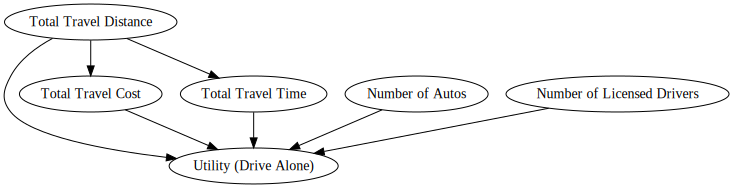

In [647]:
# Define the causal model
V_drive_alone = CausalGraphicalModel(nodes_da, edges_da)

# draw the causal model
V_drive_alone.draw()

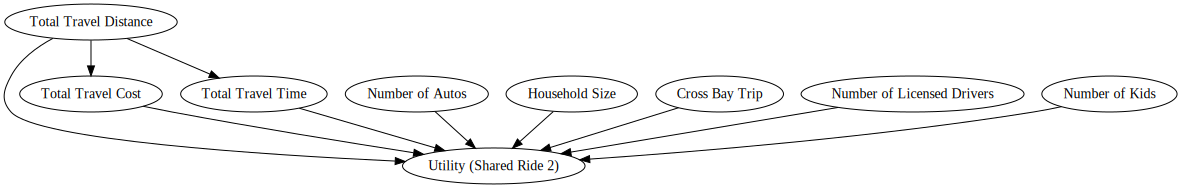

In [648]:
# Define the causal model
V_shared_2 = CausalGraphicalModel(nodes_shared_2, edges_shared_2)

# draw the causal model
V_shared_2.draw()

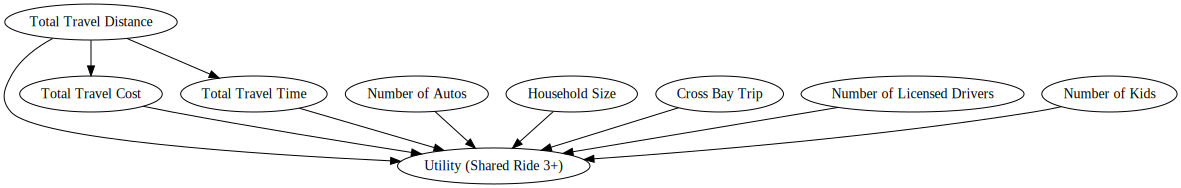

In [649]:
# Define the causal model
V_shared_3p = CausalGraphicalModel(nodes_shared_3p, edges_shared_3p)

# draw the causal model
V_shared_3p.draw()

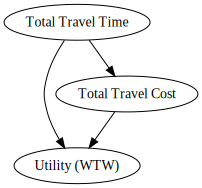

In [650]:
# Define the causal model
V_wtw = CausalGraphicalModel(nodes_wtw, edges_wtw)

# draw the causal model
V_wtw.draw()

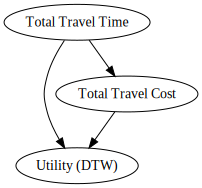

In [651]:
# Define the causal model
V_dtw = CausalGraphicalModel(nodes_dtw, edges_dtw)

# draw the causal model
V_dtw.draw()

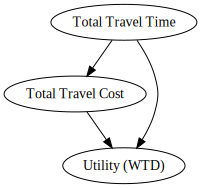

In [652]:
# Define the causal model
V_wtd = CausalGraphicalModel(nodes_wtd, edges_wtd)

# draw the causal model
V_wtd.draw()

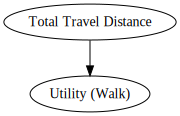

In [653]:
# Define the causal model
V_walk = CausalGraphicalModel(nodes_walk, edges_walk)

# draw the causal model
V_walk.draw()

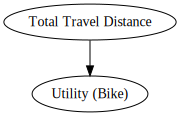

In [654]:
# Define the causal model
V_bike = CausalGraphicalModel(nodes_bike, edges_bike)

# draw the causal model
V_bike.draw()

## 3.2. Find Distribution of Nodes without parents

In [655]:
bike_data_params = get_dist_node_no_parent(bike_data_long,
                                           ALT_ID_COL,
                                           OBS_ID_COL,
                                           ALT_SPEC_DICT,
                                           ALT_NAME_DICT,
                                           IND_SPEC_VARS,
                                           TRIP_SPEC_VARS,
                                           VARS_TYPE,
                                           CONT_DISTS)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------
Fitted norm distribution with error=0.014164054487182288)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014136723006166226)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.014117434128009247)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
Fitted norm distribution with error=0.0004036911862300816

## 3.3. Regressions for each causal graph 

### 3.3.1. Drive Alone 

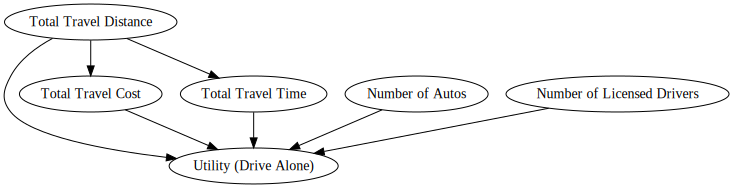

In [656]:
V_drive_alone.draw()

In [657]:
drive_alone_df = bike_data_long.loc[bike_data_long['mode_id'] == 1]

drive_alone_df.reset_index(drop=True, inplace=True)

fitted_reg_da = fit_alternative_regression(regressions_da,
                                           regs_type_da,
                                           drive_alone_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.2. Shared-2

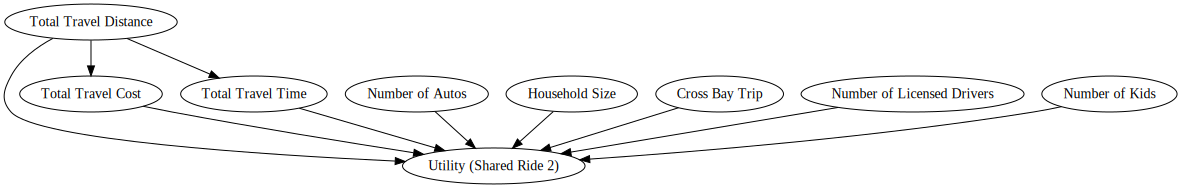

In [658]:
V_shared_2.draw()

In [659]:
shared_2_df = bike_data_long.loc[bike_data_long['mode_id'] == 2]

shared_2_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_2 = fit_alternative_regression(regs_shared_2,
                                                 regs_type_shared_2,
                                                 shared_2_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.3. Shared-3+

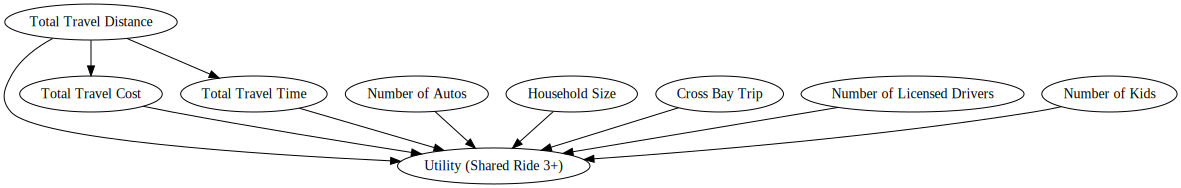

In [660]:
V_shared_3p.draw()

In [661]:
shared_3p_df = bike_data_long.loc[bike_data_long['mode_id'] == 3]

shared_3p_df.reset_index(drop=True, inplace=True)

fitted_reg_shared_3p = fit_alternative_regression(regs_shared_3p,
                                                  regs_type_shared_3p,
                                                  shared_3p_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.4. Walk-Transit-Walk 

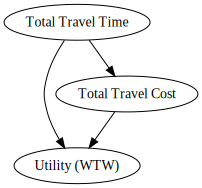

In [662]:
V_wtw.draw()

In [663]:
wtw_df = bike_data_long.loc[bike_data_long['mode_id'] == 4]

wtw_df.reset_index(drop=True, inplace=True)

fitted_reg_wtw = fit_alternative_regression(regs_wtw,
                                            regs_type_wtw,
                                            wtw_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.5. Drive-Transit-Walk 

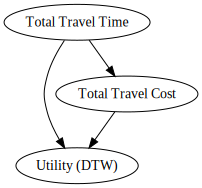

In [664]:
V_dtw.draw()

In [665]:
dtw_df = bike_data_long.loc[bike_data_long['mode_id'] == 5]

dtw_df.reset_index(drop=True, inplace=True)

fitted_reg_dtw = fit_alternative_regression(regs_dtw,
                                            regs_type_dtw,
                                            dtw_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.6. Walk-Transit-Drive 

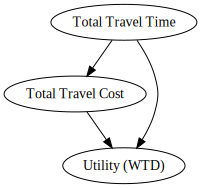

In [666]:
V_wtd.draw()

In [667]:
wtd_df = bike_data_long.loc[bike_data_long['mode_id'] == 6]

wtd_df.reset_index(drop=True, inplace=True)

wtd_reg = fit_alternative_regression(regs_wtd,
                                     regs_type_wtd,
                                     wtd_df)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.3.7. Walk

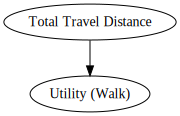

In [668]:
V_walk.draw()

No regressions needed under the Walk alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

### 3.3.8. Bike

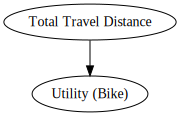

In [669]:
V_bike.draw()

No regressions needed under the Bike alternative since the travel distance will be simulated based on the original dataset and directly affects the utility function

## 3.4. Simulate Nodes without Parents 

In [670]:
sim_bike_data_no_parent = sim_node_no_parent(bike_data_params, size=SIM_SIZE)

## 3.5. Simulate data for each causal graph

In [671]:
# Create a copy of the data to avoid any issues
sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

### 3.5.1. Drive Alone 

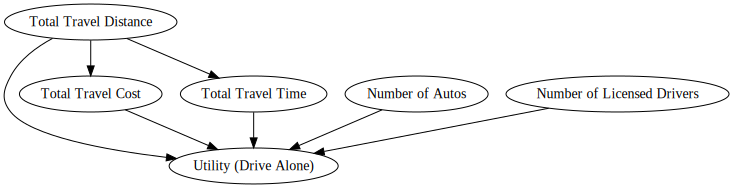

In [672]:
V_drive_alone.draw()

In [675]:
sim_bike_data_wide['total_travel_time_drive_alone'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_drive_alone'],
                 drive_alone_reg['total_travel_time_on_total_travel_distance'],
                 SIM_SIZE)

###################################

sim_bike_data_wide['total_travel_cost_drive_alone'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_drive_alone'],
                 drive_alone_reg['total_travel_cost_on_total_travel_distance'],
                 SIM_SIZE)

### 3.5.2. Shared-2 

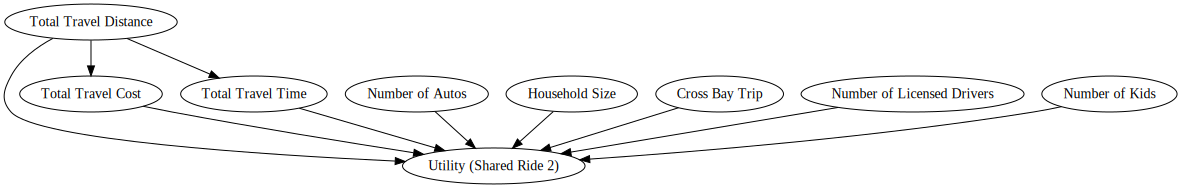

In [676]:
V_shared_2.draw()

In [677]:
sim_bike_data_wide['total_travel_time_shared_2'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_2'],
                 shared_2_reg['total_travel_time_on_total_travel_distance'],
                 SIM_SIZE)

###################################

sim_bike_data_wide['total_travel_cost_shared_2'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_2'],
                 shared_2_reg['total_travel_cost_on_total_travel_distance'],
                 SIM_SIZE)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.5.3. Shared-3+

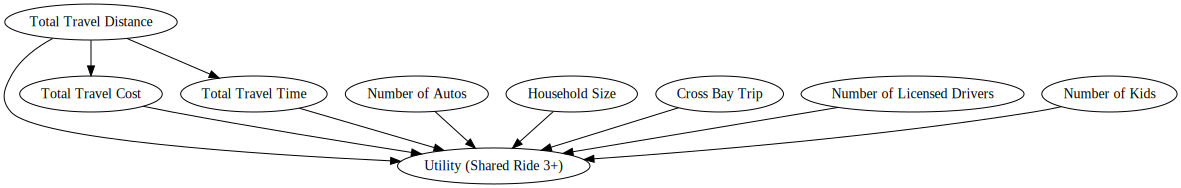

In [678]:
V_shared_3p.draw()

In [679]:
sim_bike_data_wide['total_travel_time_shared_3p'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_3p'],
                 shared_3p_reg['total_travel_time_on_total_travel_distance'],
                 SIM_SIZE)

###################################

sim_bike_data_wide['total_travel_cost_shared_3p'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_3p'],
                 shared_3p_reg['total_travel_cost_on_total_travel_distance'],
                 SIM_SIZE)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.5.4. Walk-Transit-Walk

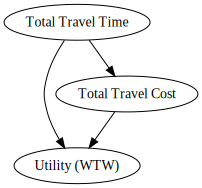

In [680]:
V_wtw.draw()

In [681]:
sim_bike_data_wide['total_travel_cost_wtw'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_time_wtw'],
                 wtw_reg['total_travel_cost_on_total_travel_time'],
                 SIM_SIZE)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.5.5. Drive-Transit-Walk

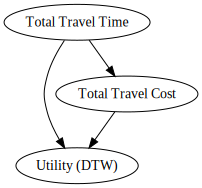

In [682]:
V_dtw.draw()

In [683]:
sim_bike_data_wide['total_travel_cost_dtw'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_time_dtw'],
                 dtw_reg['total_travel_cost_on_total_travel_time'],
                 SIM_SIZE)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.5.6. Walk-Transit-Drive

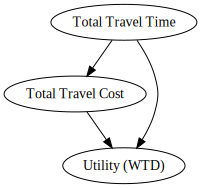

In [684]:
V_wtd.draw()

In [685]:
sim_bike_data_wide['total_travel_cost_wtd'] =\
    lin_reg_pred(sim_bike_data_wide['total_travel_time_wtd'],
                 wtd_reg['total_travel_cost_on_total_travel_time'],
                 SIM_SIZE)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### 3.5.7. Walk

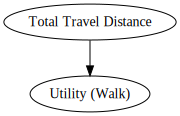

In [686]:
V_walk.draw()

No need to simulate any other variables since Walk Total Travel Distance was already simulated

### 3.5.8. Bike

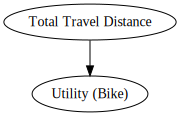

In [687]:
V_bike.draw()

No need to simulate any other variables since Bike Total Travel Distance was already simulated

## 3.6. Simulate Availability of Alternatives 

In [688]:
# Simulate availability, add fake choice column
# and return final simulated data with availability
# and choices
alt_av_matrix = simulate_availability(bike_data_long,
                                      OBS_ID_COL,
                                      ALT_NAME_DICT,
                                      SIM_SIZE)

In [689]:
sim_bike_data_wide = sim_bike_data_wide.join(alt_av_matrix)

In [690]:
sim_bike_data_wide['sim_choice'] = sim_fake_choice_col(alt_av_matrix)

# Create a custom id column that ignores the fact that this is a
# panel/repeated-observations dataset.
# Note the +1 ensures the id's start at one.
sim_bike_data_wide[obs_id_column] = np.arange(sim_bike_data_wide.shape[0],
                                              dtype=int) + 1

## 3.7. Convert Simulated Data from Wide to Long

In [691]:
# Convert data from wide to long
long_sim_data = pl.convert_wide_to_long(sim_bike_data_wide,
                                        ind_variables,
                                        alt_varying_variables,
                                        availability_variables,
                                        obs_id_column,
                                        choice_column,
                                        custom_alt_id)

In [692]:
# Create a cars per licensed drivers column
long_sim_data["cars_per_licensed_drivers"] = 0
long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                  "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

4:80: E501 line too long (122 > 79 characters)


In [693]:
# Add a variable representing cost divided by distance
long_sim_data["cost_per_distance"] = 0
long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                  "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_cost"] /
                                          long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                            "total_travel_distance"])

4:80: E501 line too long (98 > 79 characters)
5:80: E501 line too long (82 > 79 characters)
6:80: E501 line too long (98 > 79 characters)
7:80: E501 line too long (85 > 79 characters)


## 3.8. Simulate Choices 

In [694]:
# Calculate probabilities for each alternative
# based on the estimated model
init_mnl_model_prob = mnl_model.predict(long_sim_data)

/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))


In [695]:
# Simulate choice data
long_sim_data['sim_choice'] = viz.simulate_choice_vector(init_mnl_model_prob,
                                                         long_sim_data['observation_id'].values)

3:80: E501 line too long (96 > 79 characters)


## 3.9. Estimate Model

In [696]:
# Estimate the basic MNL model, using the hessian and newton-conjugate gradient
mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                       alt_id_col=alternative_id_col,
                                       obs_id_col=observation_id_col,
                                       choice_col=choice_column,
                                       specification=mnl_specification,
                                       model_type="MNL",
                                       names=mnl_names)

num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))

# Note newton-cg used to ensure convergence to a point where gradient
# is essentially zero for all dimensions.
mnl_model_sim.fit_mle(np.zeros(num_vars),
                      method="BFGS")

# Look at the estimation results
mnl_model_sim.get_statsmodels_summary()

Log-likelihood at zero: -15,205.1705
Initial Log-likelihood: -15,205.1705


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimation Time for Point Estimation: 0.73 seconds.
Final log-likelihood: -5,600.4500


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                  sim_choice   No. Observations:                8,000
Model:             Multinomial Logit Model   Df Residuals:                    7,981
Method:                                MLE   Df Model:                           19
Date:                     Sun, 24 May 2020   Pseudo R-squ.:                   0.632
Time:                             21:01:01   Pseudo R-bar-squ.:               0.630
AIC:                            11,238.900   Log-Likelihood:             -5,600.450
BIC:                            11,371.657   LL-Null:                   -15,205.170
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
ASC Shared Ride: 2                                      -1.0345      0.131     -7.887      0.000      -1.292      -0.777
ASC Shared Ride: 3+                                      3.5060      0.195     17.954      0.000       3.123       3.889
ASC Walk-Transit-Walk                                   -0.6175      0.139     -4.436      0.000      -0.890      -0.345
ASC Drive-Transit-Walk                                  -2.7295      0.147    -18.611      0.000      -3.017      -2.442
ASC Walk-Transit-Drive                                  -3.2776      0.159    -20.636      0.000      -3.589      -2.966
ASC Walk                                                 1.4931      0.141     10.584      0.000       1.217       1.770
ASC Bike                                                -1.1420      0.113    -10.089      0.000      -1.364      -0.920
Travel Time, units:min (All Auto Modes)                 -0.0751      0.002    -33.330      0.000      -0.080      -0.071
Travel Time, units:min (All Transit Modes)              -0.0245      0.001    -16.876      0.000      -0.027      -0.022
Travel Cost, units:$ (All Transit Modes)                -0.1418      0.019     -7.347      0.000      -0.180      -0.104
Travel Cost per Distance, units:$/mi (Drive Alone)      -5.1721      0.189    -27.320      0.000      -5.543      -4.801
Travel Cost per Distance, units:$/mi (SharedRide-2)    -20.7810      0.649    -32.038      0.000     -22.052     -19.510
Travel Cost per Distance, units:$/mi (SharedRide-3+)   -92.7761      2.638    -35.164      0.000     -97.947     -87.605
Autos per licensed drivers (All Auto Modes)              1.1998      0.060     20.110      0.000       1.083       1.317
Travel Distance, units:mi (Walk)                        -1.0078      0.036    -27.830      0.000      -1.079      -0.937
Travel Distance, units:mi (Bike)                        -0.2909      0.015    -19.026      0.000      -0.321      -0.261
Cross-Bay Tour (Shared Ride 2 & 3+)                      1.0437      0.151      6.899      0.000       0.747       1.340
Household Size (Shared Ride 2 & 3+)                      0.1201      0.029      4.169      0.000       0.064       0.177
Number of Kids in Household (Shared Ride 2 & 3+)         0.7168      0.035     20.591      0.000       0.649       0.785
========================================================================================================================
"""

12:70: W291 trailing whitespace
13:42: W291 trailing whitespace


# 5. Repeat Simulation N times and compute Average Causal Effects

### 5.1. Run the repeated simulation

In [697]:
simulation_sizes = np.random.randint(low=3000, high=9000, size=2)
sim_number = np.arange(1, 3)
models_dictionary = defaultdict(dict)
causal_effect_dictionary = {}
perturb = 0.8
simulation_data = {}

for sim_size, number in zip(simulation_sizes, sim_number):
    print('Simulation number', number, 'is in progress...')
    print('Simulation size is', sim_size)
    print('------------------------------------------')
    print('Simulating data...')
    # Simulate data without parents
    sim_bike_data_no_parent = sim_node_no_parent(bike_data_params,
                                                 size=sim_size)

    sim_bike_data_wide = copy.deepcopy(sim_bike_data_no_parent)

    # Simulate nodes based on causal graphs
    # Drive Alone
    sim_bike_data_wide['total_travel_time_drive_alone'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_drive_alone'],
                     drive_alone_reg['total_travel_time_on_total_travel_distance'],
                     sim_size)

    sim_bike_data_wide['total_travel_cost_drive_alone'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_drive_alone'],
                     drive_alone_reg['total_travel_cost_on_total_travel_distance'],
                     sim_size)

    # Shared Ride 2
    sim_bike_data_wide['total_travel_time_shared_2'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_2'],
                     shared_2_reg['total_travel_time_on_total_travel_distance'],
                     sim_size)

    sim_bike_data_wide['total_travel_cost_shared_2'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_2'],
                     shared_2_reg['total_travel_cost_on_total_travel_distance'],
                     sim_size)

    # Shared Ride 3+
    sim_bike_data_wide['total_travel_time_shared_3p'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_3p'],
                     shared_3p_reg['total_travel_time_on_total_travel_distance'],
                     sim_size)

    sim_bike_data_wide['total_travel_cost_shared_3p'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_distance_shared_3p'],
                     shared_3p_reg['total_travel_cost_on_total_travel_distance'],
                     sim_size)

    # Walk-Transit-Walk
    sim_bike_data_wide['total_travel_cost_wtw'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_time_wtw'],
                     wtw_reg['total_travel_cost_on_total_travel_time'],
                     sim_size)

    # Drive-Transit-Walk
    sim_bike_data_wide['total_travel_cost_dtw'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_time_dtw'],
                     dtw_reg['total_travel_cost_on_total_travel_time'],
                     sim_size)

    # Walk-Transit-Drive
    sim_bike_data_wide['total_travel_cost_wtd'] =\
        lin_reg_pred(sim_bike_data_wide['total_travel_time_wtd'],
                     wtd_reg['total_travel_cost_on_total_travel_time'],
                     sim_size)

    # Simulate Availability
    print('Simulating Availability...')
    alt_av_matrix = simulate_availability(data_long=bike_data_long,
                                          obs_id_col=observation_id_col,
                                          alt_name_dict=alternative_name_dict,
                                          sim_size=sim_size)

    sim_bike_data_wide = sim_bike_data_wide.join(alt_av_matrix)

    sim_bike_data_wide['sim_choice'] = sim_fake_choice_col(alt_av_matrix)

    sim_bike_data_wide[obs_id_column] = np.arange(sim_bike_data_wide.shape[0],
                                                  dtype=int) + 1

    # Converting Data from Wide to Long
    print('Converting data from wide to long...')
    long_sim_data = pl.convert_wide_to_long(sim_bike_data_wide,
                                            ind_variables,
                                            alt_varying_variables,
                                            availability_variables,
                                            obs_id_column,
                                            choice_column,
                                            new_alt_id_name=custom_alt_id)

    # Create a cars per licensed drivers column
    long_sim_data["cars_per_licensed_drivers"] = 0
    long_sim_data.loc[long_sim_data.num_licensed_drivers > 0,
                      "cars_per_licensed_drivers"] = long_sim_data.num_cars / long_sim_data.num_licensed_drivers.astype(float)

    # Add a variable representing cost divided by distance
    long_sim_data["cost_per_distance"] = 0
    long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                      "cost_per_distance"] = (long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_cost"] /
                                              long_sim_data.loc[long_sim_data.mode_id.isin([1, 2, 3]),
                                                                "total_travel_distance"])

    # Simulating Choices
    print('Simulating Choices...')
    # Calculate probabilities for each alternative
    # based on the estimated model
    init_mnl_model_probs = mnl_model.predict(long_sim_data)

    # Simulate choice data
    long_sim_data['sim_choice'] = viz.simulate_choice_vector(init_mnl_model_probs,
                                                             long_sim_data['observation_id'].values)

    # Estimating Choice Models
    print('Estimating the choice model...')
    # Estimate the basic MNL model, using the hessian and newton-conjugate gradient
    mnl_model_sim = pl.create_choice_model(data=long_sim_data,
                                           alt_id_col=alternative_id_col,
                                           obs_id_col=observation_id_col,
                                           choice_col=choice_column,
                                           specification=mnl_specification,
                                           model_type="MNL",
                                           names=mnl_names)

    num_vars = len(reduce(lambda x, y: x + y, mnl_names.values()))
    # Note newton-cg used to ensure convergence to a point where gradient
    # is essentially zero for all dimensions.
    mnl_model_sim_params = mnl_model_sim.fit_mle(np.zeros(num_vars),
                                                 method="BFGS",
                                                 just_point=True)
    mnl_model_sim_param_list = [mnl_model_sim_params['x'], None, None, None]
    # mnl_model_sim.coefs.name = 'simulation_' + str(number)
    models_dictionary[number] = mnl_model_sim

    print('Estimating Causal Effects...')

    # Estimating Causal Effects
    # Create copies of long format data
    long_sim_data_naive = copy.deepcopy(long_sim_data)
    long_sim_data_causal = copy.deepcopy(long_sim_data)

    # Initial Probabilities
    init_mnl_model_sim_probs = mnl_model_sim.predict(long_sim_data,
                                                     param_list=mnl_model_sim_param_list)

    long_sim_data['init_mnl_model_sim_probs'] = init_mnl_model_sim_probs

    # mnl_model_probs = mnl_model.predict(long_sim_data)
    long_sim_data['init_mnl_model_probs'] = init_mnl_model_probs

    # Naive Probabilities
    long_sim_data_naive['total_travel_distance'] = perturb * long_sim_data_naive['total_travel_distance']

    naive_probabilities = mnl_model_sim.predict(long_sim_data_naive,
                                                param_list=mnl_model_sim_param_list)

    long_sim_data_naive['naive_probabilities'] = naive_probabilities

    # Estimated Probabilities

    long_sim_data_causal['total_travel_distance'] = perturb * long_sim_data['total_travel_distance']

    # Perturb Variables based on Assumed Causal Graph

    # Drive Alone
#     long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_time'] = \
#                                                   (Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[0] + \
#                                                    2*Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].params[1] * \
#                                                    long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
#                                                    np.random.normal(loc=0,
#                                                                    scale = Drive_Alone_Reg['total_travel_time_on_total_travel_distance'].resid.std(),
#                                                                    size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

#     long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_cost'] = \
#                                                  (Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[0] +\
#                                                   2*Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].params[1] *\
#                                                   long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1,'total_travel_distance'] +\
#                                                   np.random.normal(loc=0,
#                                                                    scale = Drive_Alone_Reg['total_travel_cost_on_total_travel_distance'].resid.std(),
#                                                                    size = long_sim_data_causal.loc[long_sim_data_causal['mode_id']==1].shape[0]))

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_time'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_distance'],
                     drive_alone_reg['total_travel_time_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1, 'total_travel_distance'],
                     drive_alone_reg['total_travel_cost_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 1].shape[0])

    # Shared-2

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_time'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_distance'],
                     shared_2_reg['total_travel_time_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2, 'total_travel_distance'],
                     shared_2_reg['total_travel_cost_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 2].shape[0])

    # Shared 3+
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_time'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_distance'],
                     shared_3p_reg['total_travel_time_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3, 'total_travel_distance'],
                     shared_3p_reg['total_travel_cost_on_total_travel_distance'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 3].shape[0])

    # Walk-Transit-Walk
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4, 'total_travel_time'],
                     wtw_reg['total_travel_cost_on_total_travel_time'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 4].shape[0])

    # Drive-Transit-Walk
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5, 'total_travel_time'],
                     dtw_reg['total_travel_cost_on_total_travel_time'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 5].shape[0])

    # Walk-Transit-Drive
    long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6, 'total_travel_cost'] =\
        lin_reg_pred(long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6, 'total_travel_time'],
                     wtd_reg['total_travel_cost_on_total_travel_time'],
                     long_sim_data_causal.loc[long_sim_data_causal['mode_id'] == 6].shape[0])

    # Compute Estimated Probabilities
    estimated_probabilities = mnl_model_sim.predict(long_sim_data_causal,
                                                    param_list=mnl_model_sim_param_list)
    long_sim_data_causal['estimated_probabilities'] = estimated_probabilities

    # True Probabilities
    true_probabilities = mnl_model.predict(long_sim_data_causal)
    long_sim_data_causal['true_probabilities'] = true_probabilities

    simulation_data[number] = {}
    simulation_data[number]['long_sim_data'] = long_sim_data
    simulation_data[number]['long_sim_data_causal'] = long_sim_data_causal
    simulation_data[number]['long_sim_data_naive'] = long_sim_data_naive

    print('Simulation number', number, 'is complete!')
    print('==========================================')
    print('==========================================')

Simulation number 1 is in progress...
Simulation size is 7739
------------------------------------------
Simulating data...
Simulating Availability...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Converting data from wide to long...
Simulating Choices...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Simulation number 1 is complete!
Simulation number 2 is in progress...
Simulation size is 6799
------------------------------------------
Simulating data...
Simulating Availability...
Converting data from wide to long...
Simulating Choices...



Estimating the choice model...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_minimize.py:505: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  RuntimeWarning)


Estimating Causal Effects...


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/pylogit/choice_tools.py:703: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  design_matrix = np.hstack((x[:, None] for x in independent_vars))
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
23:80: E501 line too long (83 > 79 characters)
28:80: E501 line too long (83 > 79 characters)
34:80: E501 line too long (80 > 79 characters)
39:80: E501 line too long (80 > 79 characters)
45:80: E501 line too long (81 > 79 characters)
50:80: E501 line too long (81 > 79 characters)
98:80: E501 line too long (126 > 79 characters)
103:80: E501 line too long (102 > 79 characters)
104:

Simulation number 2 is complete!


In [698]:
causal_effects = pd.DataFrame(columns=['naive_effect', 'true_effect', 'estimated_effect'])
for number in sim_number:
    initial_data = simulation_data[number]['long_sim_data']
    naive_data = simulation_data[number]['long_sim_data_naive']
    causal_data = simulation_data[number]['long_sim_data_causal']

    naive_effect = naive_data.loc[naive_data['mode_id'].isin([1, 2, 3]), 'naive_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_sim_probs']
    estimated_effect = causal_data.loc[causal_data['mode_id'].isin([1, 2, 3]), 'estimated_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_sim_probs']
    true_effect = causal_data.loc[causal_data['mode_id'].isin([1, 2, 3]), 'true_probabilities'] -\
        initial_data.loc[initial_data['mode_id'].isin([1, 2, 3]), 'init_mnl_model_probs']

    causal_effects = causal_effects.append({'true_effect': true_effect.mean(),
                                            'estimated_effect': estimated_effect.mean(),
                                            'naive_effect': naive_effect.mean()}, ignore_index=True)

1:80: E501 line too long (90 > 79 characters)
7:80: E501 line too long (98 > 79 characters)
8:80: E501 line too long (93 > 79 characters)
9:80: E501 line too long (108 > 79 characters)
10:80: E501 line too long (93 > 79 characters)
11:80: E501 line too long (98 > 79 characters)
12:80: E501 line too long (89 > 79 characters)
15:80: E501 line too long (88 > 79 characters)
16:80: E501 line too long (100 > 79 characters)


# 5. Plotting results of the simulation 

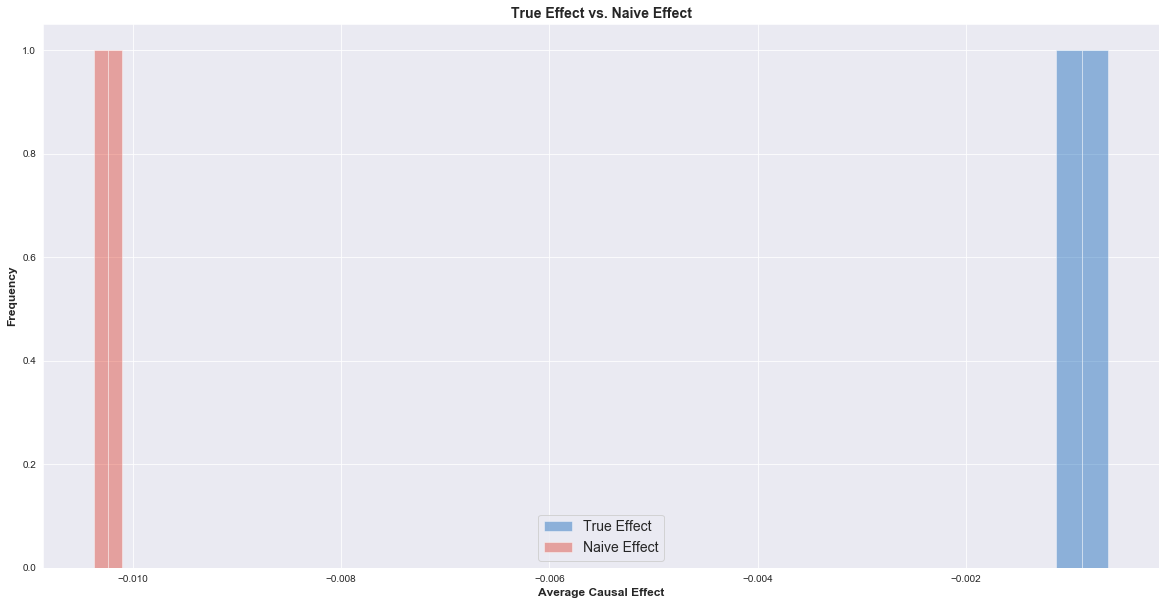

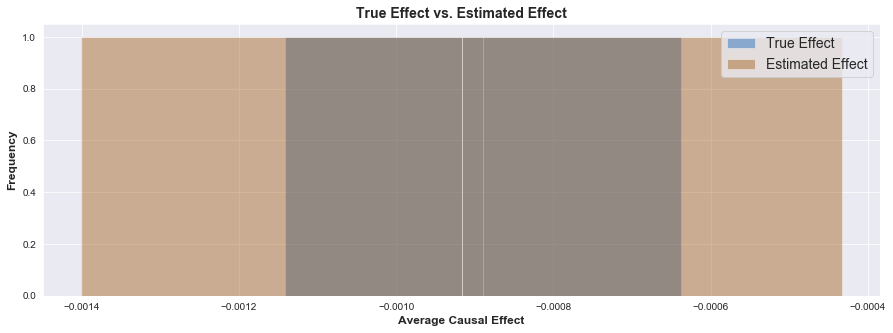

2:80: E501 line too long (89 > 79 characters)
3:80: E501 line too long (91 > 79 characters)
4:80: E501 line too long (90 > 79 characters)
5:80: E501 line too long (97 > 79 characters)
6:80: E501 line too long (84 > 79 characters)
10:80: E501 line too long (89 > 79 characters)
11:80: E501 line too long (99 > 79 characters)
12:80: E501 line too long (94 > 79 characters)
13:80: E501 line too long (97 > 79 characters)
14:80: E501 line too long (84 > 79 characters)


In [699]:
plt.figure(figsize=(20, 10))
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='#005AB5')
sns.distplot(causal_effects.naive_effect, label='Naive Effect', kde=False, color='#DC3220')
plt.title('True Effect vs. Naive Effect', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.legend(prop={'size': 14})

plt.figure(figsize=(15, 5))
sns.distplot(causal_effects.true_effect, label='True Effect', kde=False, color='#005AB5')
sns.distplot(causal_effects.estimated_effect, label='Estimated Effect', kde=False, color='#994F00')
plt.title('True Effect vs. Estimated Effect', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Frequency', rotation=90, labelpad=5, fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.xlabel('Average Causal Effect', fontdict={'fontsize': 12, 'fontweight': 'bold'})
plt.legend(prop={'size': 14})

Assert that the absolute value of the difference between the naive and true causal effects is greater than the absolute value of the difference between estimated and true causal effects. This we can specify in the future what we think a significant difference between the sides of the inequality should be.

In [237]:
assert abs(np.mean(naive_effect) - np.mean(true_effect)) > abs(np.mean(estimated_effect) - np.mean(true_effect))

In [468]:
import unittest

class TestSuite(unittest.TestCase):
    
    PATH = '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'
    data_long = pd.read_csv(PATH)

    def test_DistNodeNoParent(self):
        # Setup
        alternative_id_col = "mode_id"
        observation_id_col = "observation_id"
        alternative_specific_dic = {1:['total_travel_distance'],
                                    2:['total_travel_distance'],
                                    3:['total_travel_distance'],
                                    4:['total_travel_time'],
                                    5:['total_travel_time'],
                                    6:['total_travel_time'],
                                    7:['total_travel_distance'],
                                    8:['total_travel_distance']}

        alternative_name_dic = {1: 'drive_alone',
                                2: 'shared_2',
                                3: 'shared_3p',
                                4: 'wtw',
                                5: 'dtw',
                                6: 'wtd',
                                7: 'walk',
                                8: 'bike'}

        individual_specific_variables = ["household_size", "num_kids",
                                         "num_cars", "num_licensed_drivers"]
        trip_specific_variables = ["cross_bay"]
        variable_type = {'num_kids': 'categorical',
                         'household_size': 'categorical',
                         'num_cars': 'categorical',
                         'num_licensed_drivers': 'categorical',
                         'cross_bay': 'categorical',
                         'total_travel_time': 'continuous',
                         'total_travel_distance': 'continuous',
                         'total_travel_cost': 'continuous'}

        distributions = ['normal', 'alpha', 'beta', 'gamma', 'expon', 'gumbel']


        # Exercise
        params_dic = get_dist_node_no_parent(data_long=self.data_long, 
                                       alt_id_col=alternative_id_col,
                                       obs_id_col=observation_id_col,
                                       alt_spec_dic=alternative_specific_dic,
                                       alt_name_dic=alternative_name_dic,
                                       ind_spec=individual_specific_variables,
                                       trip_spec=trip_specific_variables,
                                       var_types=variable_type,
                                       cont_dists=distributions)

        # Verify
        truth_params_dic = {'household_size': {'distribution': 'categorical',
                            'parameters': [np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
                               np.array([0., 0.08341658, 0.2465035 , 0.20704296, 0.29220779,
                                      0.12012987, 0.02997003, 0.00949051, 0.01123876])]},
                             'num_kids': {'distribution': 'categorical',
                              'parameters': [np.array([0, 1, 2, 3, 4, 5, 6]),
                               np.array([0.46603397, 0.17682318, 0.25624376, 0.07642358, 0.01598402,
                                      0.00699301, 0.0014985 ])]},
                             'num_cars': {'distribution': 'categorical',
                              'parameters': [np.array([0., 1., 2., 3., 4., 5., 6., 7., 8.]),
                               np.array([0.0516983 , 0.23976024, 0.48676324, 0.17057942, 0.03996004,
                                      0.00674326, 0.0024975 , 0.000999  , 0.000999  ])]},
                             'num_licensed_drivers': {'distribution': 'categorical',
                              'parameters': [np.array([0., 1., 2., 3., 4., 5., 6.]),
                               np.array([1.12387612e-02, 1.45604396e-01, 6.15134865e-01, 1.73576424e-01,
                                      4.47052947e-02, 9.24075924e-03, 4.99500500e-04])]},
                             'total_travel_distance_drive_alone': {'distribution': 'gamma',
                              'parameters': (0.7944517942940816, 0.39999999999999997, 19.10566310726253)},
                             'total_travel_distance_shared_2': {'distribution': 'gamma',
                              'parameters': (0.8148950757692075, 0.29999999999999993, 18.40250347572789)},
                             'total_travel_distance_shared_3p': {'distribution': 'gamma',
                              'parameters': (0.8135746709638757, 0.29999999999999993, 18.437320030510342)},
                             'total_travel_time_wtw': {'distribution': 'alpha',
                              'parameters': (3.9577465114167927, -98.3112671568787, 749.7787691208105)},
                             'total_travel_time_dtw': {'distribution': 'gamma',
                              'parameters': (2.6059274863539046, 8.099701135792749, 30.976197249989433)},
                             'total_travel_time_wtd': {'distribution': 'gamma',
                              'parameters': (2.547895345348514, 7.666262097694567, 30.99344922438852)},
                             'total_travel_distance_walk': {'distribution': 'alpha',
                              'parameters': (1.985330145127784e-06,
                               -1.6062753376988779,
                               5.430955769911186)},
                             'total_travel_distance_bike': {'distribution': 'alpha',
                              'parameters': (0.0023562351887384068,
                               -1.4282411165328406,
                               4.999096383807641)},
                             'cross_bay': {'distribution': 'categorical',
                              'parameters': [np.array([0, 1]), np.array([0.94005994, 0.05994006])]}}

        for k in truth_params_dic.keys():
            np.testing.assert_string_equal(truth_params_dic[k]['distribution'], params_dic[k]['distribution'])
            np.testing.assert_array_almost_equal(truth_params_dic[k]['parameters'], params_dic[k]['parameters'])
            
    def test_sim_node_no_parent(self):
        # Setup
        params_dict = {'x':{'distribution': 'categorical',
                            'parameters': [np.array([0, 1, 2]),
                                           np.array([0.5, 0.25, 0.25])]},
                       'y':{'distribution': 'constant',
                            'parameters': 5 },
                       'z':{'distribution': 'norm',
                            'parameters': (20, 1.2)}
                      }
        
        # Exercise
        actual_data = sim_node_no_parent(params_dict, size=100000)
        
        # Verify
        x = np.random.choice(a=[0, 1, 2], p=[0.5, 0.25, 0.25], size=100000)
        y = [5]*100000
        z = scipy.stats.norm.rvs(loc=20,scale=1.2, size=100000)
        expected_data = pd.DataFrame(data={'x': x, 'y': y, 'z': z})
        np.testing.assert_array_less(abs(expected_data['x'].mean() - actual_data['x'].mean()), 0.01)
        np.testing.assert_array_equal(expected_data['y'].unique(), actual_data['y'].unique())
        np.testing.assert_array_less(abs(expected_data['z'].mean() - actual_data['z'].mean()), 0.1) # the 0.1 can be discussed
        np.testing.assert_array_less(abs(expected_data['z'].std() - actual_data['z'].std()), 0.1) # the 0.1 can be discussed
        
    def test_simulate_availability(self):
        # Setup
        alternative_id_col = "mode_id"
        observation_id_col = "observation_id"
        alternative_name_dic = {1: 'drive_alone',
                                2: 'shared_2',
                                3: 'shared_3p',
                                4: 'wtw',
                                5: 'dtw',
                                6: 'wtd',
                                7: 'walk',
                                8: 'bike'}
        sim_size = len(bike_data_long[observation_id_col].unique())
        
        # Exercise -- This might need to change
        # Mainly because of the restriction on the simulation size
        # Currently, sim_size is the same length as the
        # long format dataset
        actual_av_matrix = simulate_availability(data_long=self.data_long, sim_size=sim_size, obs_id_col=observation_id_col, alt_name_dict=alternative_name_dic)
        
        # Verify
        actual_sum = actual_av_matrix.values.sum()
        expected_sum = self.data_long.groupby(observation_id_col).count()[alternative_id_col].sum()
        ratio = expected_sum/actual_sum
        difference = abs(ratio-1)
        np.testing.assert_array_less(difference, 0.05) # 0.05 can be discussed
        
    def test_fit_regression(self):
        # Setup
        x = np.random.randint(100, 3500, size=2000)
        data = pd.DataFrame(data=x, columns=['x'])
        data['y'] = 5 * data['x'] + 2
        regressions = {1:('x', 'y')}
        reg_types = {1:'linear'}
        
        #Exercise
        fitted_reg = fit_alternative_regression(regressions,
                                                reg_types,
                                                data)
        
       # Verify
        const = fitted_reg['y_on_x'].params['const']
        x_par = fitted_reg['y_on_x'].params['x']
        self.assertAlmostEqual(const, 2)
        self.assertAlmostEqual(x_par, 5)
    
    def test_reg_prediction(self):
        # Setup
        x = np.random.randint(100, 3500, size=2000)
        data = pd.DataFrame(data=x, columns=['x'])
        data['y'] = 5 * data['x'] + 2
        regressions = {1:('x', 'y')}
        reg_types = {1:'linear'}
        fitted_reg = fit_alternative_regression(regressions,
                                                reg_types,
                                                data)
        # Exercise
        y_pred = lin_reg_pred(data['x'],
                              fitted_reg['y_on_x'],
                              data.shape[0])
        
        # Verify
        diff = data['y'] - y_pred
        self.assertAlmostEqual(np.mean(diff), 0)

In [469]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

Getting Distributions of Individual Specific Variables...
---------------------------------------------------------
Done...
Getting Distributions of Alternative Specific Variables...
----------------------------------------------------------
SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014522128648725777)


/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/fitter/fitter.py:411: PendingDeprecationWarning: isAlive() is deprecated, use is_alive() instead
  if it.isAlive():
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:515: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=0.0011963782652540424)
Fitted gamma distribution with error=0.0011394543473683448)
Fitted expon distribution with error=0.002052652669300775)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014457810916552023)
Fitted beta distribution with error=0.0012976882508515305)
Fitted gamma distribution with error=0.0012552378475140624)
Fitted expon distribution with error=0.0019967778289294194)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)
Fitted alpha distribution with error=0.014462601227138085)
Fitted beta distribution with error=0.001276124018206852)
Fitted gamma distribution with error=0.0012547975031013958)
Fitted expon distribution with error=0.0020004181046601524)
SKIPPED gumbel distribution (taking more than 60 seconds)
SKIPPED normal distribution (taking more than 60 seconds)

./Users/mobouzaghrane/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
..

Fitted beta distribution with error=0.0024566904071273085)
Fitted gamma distribution with error=0.0024407152169873807)
Fitted expon distribution with error=0.004178416793754377)
SKIPPED gumbel distribution (taking more than 60 seconds)
Done...
Getting Distributions of Trip Specific Variables...
---------------------------------------------------------
Done...


..
----------------------------------------------------------------------
Ran 5 tests in 7.447s

OK
